# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 08

**Author 1 (sciper):** Luca Zunino (337560)  
**Author 2 (sciper):** Roberto Minini (336157)   
**Author 3 (sciper):** Roberto Ceraolo (343261)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

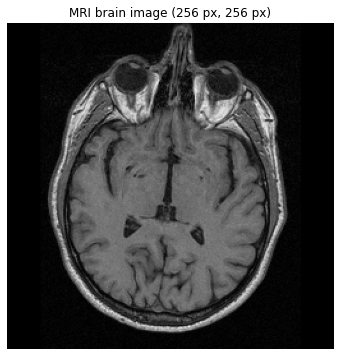

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

To get started with region growing, we have to understand what range of pixel intensity is the one related to the brain. In order to understand such range, we use the Otsu multi thresholding method, which analyzes the distribution of pixel intensity in the picture and finds a certain number of thresholds. Click [here](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html) to check the source for the Otsu multi thresholding method.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.


# Applying multi-Otsu threshold for the default value, generating
# three classes.

def plot_multi_otsu(image, n_classes):

    thresholds = threshold_multiotsu(image, n_classes)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(brain_im, bins=thresholds)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(brain_im, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(brain_im.ravel(), bins=255)
    ax[1].set_title('Histogram')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap='jet')
    ax[2].set_title('Multi-Otsu result')
    ax[2].axis('off')

    plt.subplots_adjust()

    plt.show()
    print("The thresholds are:", thresholds)
    return thresholds
    

Now we check what number of classes is appropriate. We start with two classes.

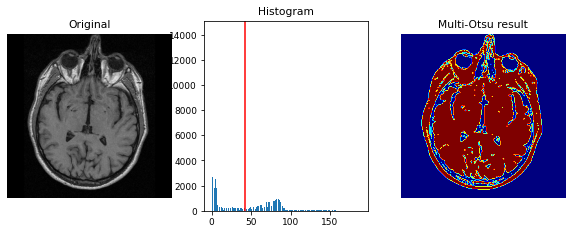

The thresholds are: [42]


In [4]:
twoclasses_thresholds = plot_multi_otsu(brain_im, 2)

As can be seen above, two classes are clearly not appropriate since the skull and brain are grouped together.

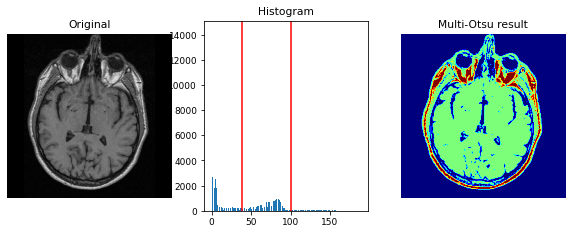

The thresholds are: [ 38 100]


In [5]:
threeclasses_thresholds = plot_multi_otsu(brain_im, 3)

Three classes do not look good enough, let's indeed take a closer look at the brain class.

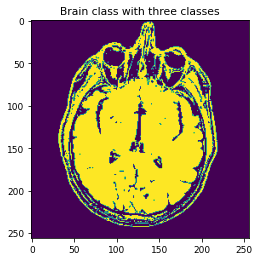

In [6]:
plt.imshow((brain_im >= 38) & (brain_im <= 100))
plt.title("Brain class with three classes")
plt.show()

As we can see, the majority of the skull is still in the same class as the brain. Hence three classes are still not enough. We now try with four.

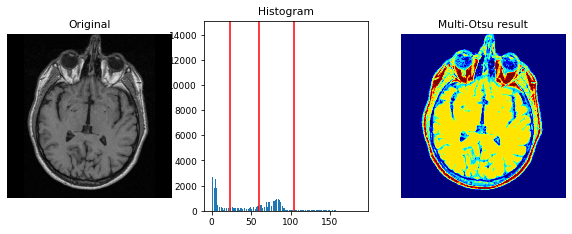

The thresholds are: [ 23  60 104]


In [7]:
fourclasses_thresholds = plot_multi_otsu(brain_im, 4)

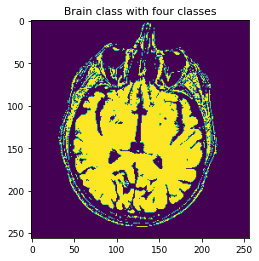

In [8]:
plt.imshow((brain_im >= 60) & (brain_im <= 104))
plt.title("Brain class with four classes")
plt.show()

Four classes look suitable for region growing because the brain and the skull seem to be separated enough. But let's check whether 5 classes would be better.

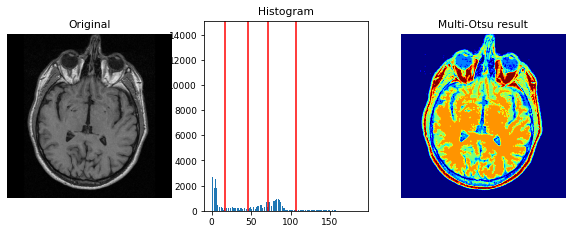

The thresholds are: [ 17  46  72 107]


In [9]:
fiveclasses_thresholds = plot_multi_otsu(brain_im, 5)

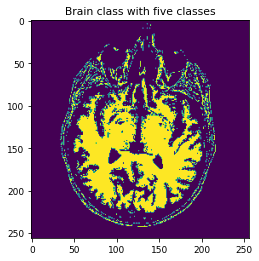

In [10]:
plt.imshow((brain_im >= 72) & (brain_im <= 107))
plt.title("Brain class with five classes")
plt.show()

Five classes are not suitable because the brain gets too eroded. So we are going to use four classes. Now we go ahead and define two functions necessary for region growing (the function has been inspired by [this](https://developpaper.com/simple-implementation-of-region-growing-in-python/) article).

In [11]:
class Point(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return f"Point ({self.x}, {self.y})"

def region_growing(img, starting_point, thresh):
    
    (height, weight) = img.shape
    result = np.zeros(img.shape)
    points_list = [starting_point] #list of points for which we need to consider neighbours
    connections = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), Point(0, 1), Point(-1, 1), Point(-1, 0)]  #each point (except for those on the border) have eight possible neighbours
    
    while len(points_list) > 0: #loop goes on untill there are still points for which we need to check neighbours
        current_point = points_list.pop(0)

        result[current_point.x, current_point.y] = 1
        for i in range(8):
            candidate_pointX = current_point.x + connections[i].x
            candidate_pointY = current_point.y + connections[i].y
            if candidate_pointX < 0 or candidate_pointY < 0 or candidate_pointX >= height or candidate_pointY >= weight: #check that the neighbour doesn't fall out the borders of the picture
                continue
            candidate_point = Point(candidate_pointX, candidate_pointY)
            pixel_intensity = int(img[candidate_point.x, candidate_point.y])
            
            (thresh_lower, thresh_higher) = thresh
            if pixel_intensity > thresh_lower and pixel_intensity < thresh_higher \
                and result[candidate_pointX, candidate_pointY] == 0:   # this is the condition based on the threshold
                result[candidate_pointX, candidate_pointY] = 1
                points_list.append(candidate_point)
    return result

def run_region_growing(image, starting_point, thresholds):

    image = region_growing(image, starting_point, thresholds) 

    plt.scatter([starting_point.y], [starting_point.x], c='r')
    plt.imshow(image)
    plt.title("Region Growing result")
    plt.show()

    percentage = np.sum(image) * 100 / (image.shape[0]
            * image.shape[1])
    print ('Number of brain pixels:', np.sum(image), 'Percentage:',
           f"{np.round(percentage, 2)}%")


To do the region grow, we need a starting point, from which the region will start to expand. in order to make sure our algorithm generalizes well to different brain scans, we are going to sample starting points which make sense. We are going to assume new brain scans will have the same size (256x256) as the one provided and that the brain will have a central position. With these assumptions in place we can randomly choose as starting point one of the central points which is in between the thresholds.

In [12]:
def choose_random_central_starting_point(image, seed = 123456):
    np.random.seed(123456)
    brain_im = image
    center_brain_im = brain_im[125 : 175, 100 : 150] #we select the central part of the image
    indices = np.where((center_brain_im > 60) & (center_brain_im < 104)) # we make sure we choose among the points which are in between the thresholds
    r = np.random.randint(0, len(indices[0]))
    r1 = indices[0][r]
    r2 = indices[1][r]
    r1 = r1 + 125    ### since r1 and r2 originally refer to a subset of the original image, we need to add back 125 and 120 respectively
    r2 =  r2 + 100
    assert brain_im[r1,r2] >= 60 and brain_im[r1,r2] <= 104
    return Point(r1, r2)

starting_point = choose_random_central_starting_point(brain_im) 
print("The starting point is:", starting_point)

The starting point is: Point (136, 108)


We now run the region growing with the starting point (plotted as a red dot) and using the thresholds determined by the Multi Otsu method.

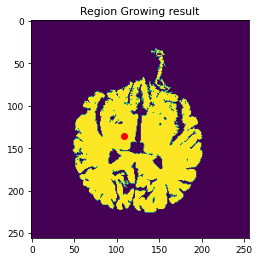

Number of brain pixels: 15468.0 Percentage: 23.6%


In [13]:
thresholds = (fourclasses_thresholds[1], fourclasses_thresholds[2])
run_region_growing(brain_im, starting_point, thresholds)

As we can see the results are very good, except for a piece of the skull which is still included together with the brain. To fix this we will use slightly modified thresholds. We are going to use the thresholds 63 and 101.

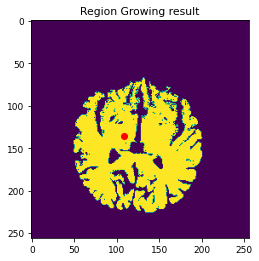

Number of brain pixels: 14431.0 Percentage: 22.02%


In [14]:
thresholds = (fourclasses_thresholds[1] + 3, fourclasses_thresholds[2] - 3)
run_region_growing(brain_im, starting_point, thresholds)

We can see that with these thresholds the result is very satisfactory.

### 1.3 Contour detection (5pts)

Here, our aim is to apply contour detection in order to identify the area of the brain. First, we apply the canny edge detection to the original image, to understand whether we need to apply some preprocessing before looking for the contours.

Canny edge detection is an edge detection algorithms that entails several different stages:
- Noise reduction
- Finding intensity gradient of the image: a Sobel kernel is used to filter the image, horizontally and vertically
- Non-maximum suppression: pixels that are not local maxima in their neighborhood in the direction of gradient are suppressed
- Hysteresis Thresholding: edges are chosen depending on the thresholds given as input.

After canny, we obtain many thin edges, so we want to close all those lines by applying a closure with a rectangular kernel. Closure applies dilation and then erosion to the image, and is used to close holes. 

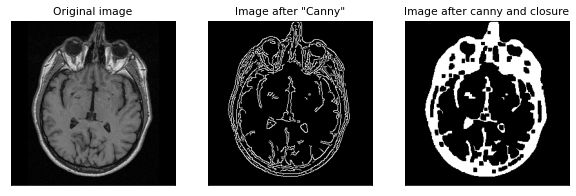

In [15]:

image_after_canny = cv2.Canny(brain_im,100,200)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
image_after_closure = cv2.morphologyEx(image_after_canny, cv2.MORPH_CLOSE, kernel) #Closing with a rectangular kern


fig, ax = plt.subplots(1, 3, figsize=(10, 10))
fig_1 = ax[0]
fig_2 = ax[1]
fig_3 = ax[2]

fig_1.imshow(brain_im,cmap = 'gray')
fig_1.set_title('Original image')
fig_1.set_xticks([])
fig_1.set_yticks([])

fig_2.imshow(image_after_canny, cmap = 'gray')
fig_2.set_title('Image after "Canny"')
fig_2.set_xticks([])
fig_2.set_yticks([])


fig_3.imshow(image_after_closure, cmap = 'gray')
fig_3.set_title('Image after canny and closure')
fig_3.set_xticks([])
fig_3.set_yticks([])

plt.show()

The function findContours of Opencv finds the contours in a binary image by using the algorothm discussed in **Satoshi Suzuki and others. Topological structural analysis of digitized binary images by border following. Computer Vision, Graphics, and Image Processing, 30(1):32–46, 1985.**.

In order to apply the findContours function and to visually inspect the contours, it may be more convenient to repeat the same procedure we did above, hence canny and closure, starting with the original image but with inverted colors.

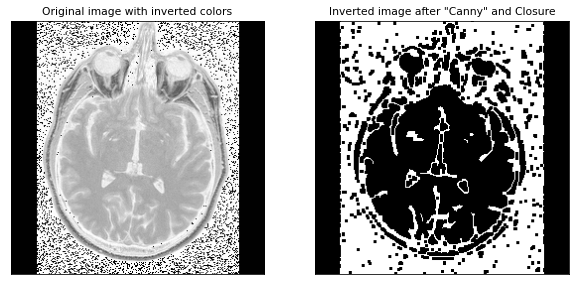

In [16]:
image_inverted =  1 - brain_im
image_after_canny = cv2.Canny(image_inverted,100,200)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
image_after_closure = cv2.morphologyEx(image_after_canny, cv2.MORPH_CLOSE, kernel) #WE APPLY CLOSING WITH A RECTANGULAR KERNEL

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig_1 = ax[0]
fig_2 = ax[1]

fig_1.imshow(image_inverted,cmap = 'gray')
fig_1.set_title('Original image with inverted colors')
fig_1.set_xticks([])
fig_1.set_yticks([])

fig_2.imshow(image_after_closure, cmap = 'gray')
fig_2.set_title('Inverted image after "Canny" and Closure')
fig_2.set_xticks([])
fig_2.set_yticks([])
plt.show()

We now apply the contour finding. We want to understand which is the contour that identifies the shape of the brain, and also remove the parts inside the contour that are not actual brain but are skull instead. We visually inspect the contours corresponding to the biggest areas.

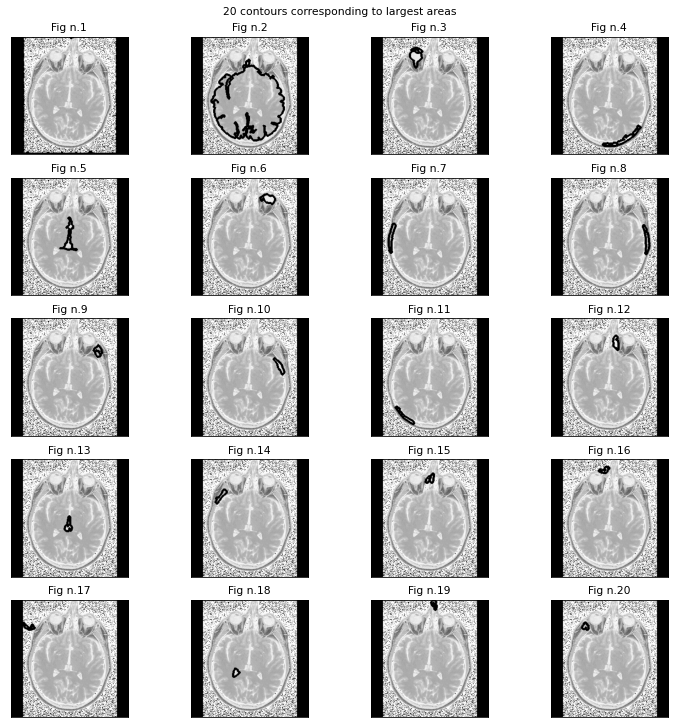

In [17]:
contours, hierarchy = cv2.findContours(image_after_closure.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
pixels = np.array([cv2.contourArea(contours[i]) for i in range(len(contours))])

n_cols = 4
n_rows = 5

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(10, 10),
                        constrained_layout=True)

i = 1
for row in range(n_rows):
    for col in range(n_cols):
        curr_fig = axs[row, col]
        curr_image_to_print_on = image_inverted.copy()
        curr_fig.imshow(cv2.drawContours(curr_image_to_print_on, contours, np.argsort(pixels)[-i], (0,255,0), 3),cmap = 'gray') #153
        curr_fig.set_title(f'Fig n.{i}')
        curr_fig.set_xticks([])
        curr_fig.set_yticks([])
        i+=1
        
fig.suptitle(f'{n_cols*n_rows} contours corresponding to largest areas')
plt.show()

From above, we can see that the contour corresponding to the brain is the one in fig. n. 2. The first one is probably the contour of the whole picture. To compute the area of the brain, we consider the area inside the contour of fig. 2, removing the parts of skull that are wrongfully included, that are the ones corresponding to fig. n. 5, 13, and 18. Probably there are also other areas that could be removed to make the computation more precise, but we decide to neglect the ones smaller that the one shown in fig. n. 20.

Final computation of the number of pixels

In [18]:
print(f"The full image size (in pixels) is {brain_im.size}")
print(f"The size of the brain as in fig. n. 2 (in pixels) is {pixels[np.argsort(pixels)[-2]]}")
size_brain = pixels[np.argsort(pixels)[-2]] - pixels[np.argsort(pixels)[-5]] - pixels[np.argsort(pixels)[-13]] - pixels[np.argsort(pixels)[-18]]
print(f"The size of the brain after the removal as described above (in pixels) is {size_brain}")


The full image size (in pixels) is 65536
The size of the brain as in fig. n. 2 (in pixels) is 18026.0
The size of the brain after the removal as described above (in pixels) is 17079.5


### 1.4 Additional methods (5pts)

#### 1.4.1 Difference based Region Growing

In this method, instead of looking at the pixel intensity of the neighbouring pixels, we look at the difference between the current pixel and the neighbouring ones.

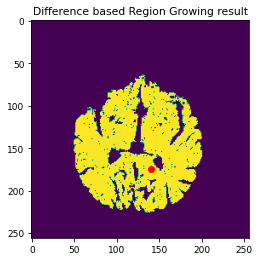

Number of brain pixels: 14936.0 Percentage: 22.79%


In [19]:
class Point(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y

def difference_based_region_growing(img, starting_point, diff_thresh):
    
    (height, weight) = img.shape
    result = np.zeros(img.shape)
    points_list = [starting_point]
    connections = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), Point(0, 1), Point(-1, 1), Point(-1, 0)]   
    
    while len(points_list) > 0:
        current_point = points_list.pop(0)

        result[current_point.x, current_point.y] = 1
        for i in range(8):
            candidate_pointX = current_point.x + connections[i].x
            candidate_pointY = current_point.y + connections[i].y
            if candidate_pointX < 0 or candidate_pointY < 0 or candidate_pointX >= height or candidate_pointY >= weight:
                continue
            candidate_point = Point(candidate_pointX, candidate_pointY)
            pixel_diff = abs(int(img[current_point.x, current_point.y]) - int(img[candidate_point.x, candidate_point.y]))
            
            if pixel_diff < diff_thresh and result[candidate_pointX, candidate_pointY] == 0:
                result[candidate_pointX, candidate_pointY] = 1
                points_list.append(candidate_point)
    return result


original_img = \
    cv2.imread(os.path.join(data_path, 'brain-slice40.tiff'),
               cv2.IMREAD_GRAYSCALE)


img = cv2.imread(os.path.join(data_path, 'brain-slice40.tiff'),
                 cv2.IMREAD_GRAYSCALE)


import matplotlib.pyplot as plt

starting_point = Point(175, 140)

thresholds = 5  # (low, high)
binaryImg = difference_based_region_growing(img, starting_point, thresholds) 

img = binaryImg

plt.scatter([starting_point.y], [starting_point.x], c='r')
plt.imshow(img)
plt.title("Difference based Region Growing result")
plt.show()

percentage = np.sum(binaryImg) * 100 / (binaryImg.shape[0]
        * binaryImg.shape[1])
print ('Number of brain pixels:', np.sum(binaryImg), 'Percentage:',
       f"{np.round(percentage, 2)}%")



#### 1.4.2 Active Contour

An alternative method we used is the [active contour method](https://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html) from the skimage library. We pass to the algorithm the thresholded image (using the Multi Otsu thresholds). The algorithm then proceeds to search for edges (the detected ones are plotted in blue).

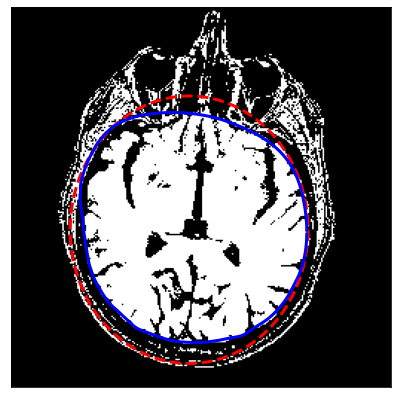

In [20]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour



img = (brain_im >= 60) & (brain_im <= 104)

s = np.linspace(0, 2*np.pi, 180)
r = 150 + 90*np.sin(s)
c = 120 + 80*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3, preserve_range=False),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

Now we create a plot of the detected boundary.

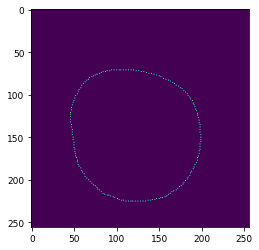

In [21]:
contour_binary_img = np.zeros((256,256))
for point in snake:
    contour_binary_img [int(point[0]), int(point[1])] = 1
plt.imshow(contour_binary_img)
plt.show()

We now proceed to fill the boundary using the convex hull method from skimage. Finally, we compute the number of pixels.

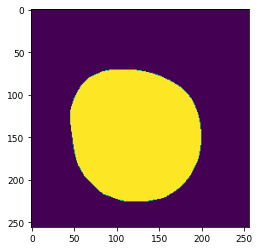

Number of brain pixels: 19451 Percentage: 29.68%


In [22]:
from skimage.morphology import convex_hull_image
hulled_img = convex_hull_image(contour_binary_img)
plt.imshow(hulled_img)
plt.show()
percentage = np.sum(hulled_img) * 100 / (hulled_img.shape[0]
        * hulled_img.shape[1])
print ('Number of brain pixels:', np.sum(hulled_img), 'Percentage:',
       f"{np.round(percentage, 2)}%")

As we can see, the results from this method are not satisfactory since the holes in the brains are not detected.

#### 1.4.3 Additional method (considering the physical meaning of the image)

The implementation of methods traditionally used to segment images is difficult because, in the MRI image analyzed, the brain has a very similar color to other parts of the skull that should not be classified as the brain. To solve this issue, a possible solution is to use additional information about the image. In particular, an interesting starting point is that, in MRI images, colours have a physical meaning.
Taking this into account, we can start removing part of the skull from the original image by considering that the skull is characterized by a high grayscale value (higher than 100). Note that the resulting image is clearer because it is automatically rescaled during plotting.

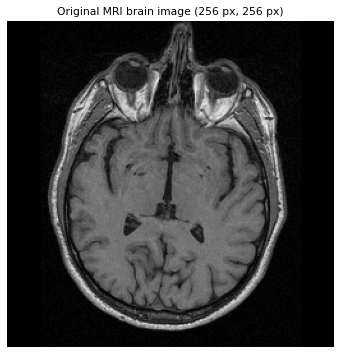

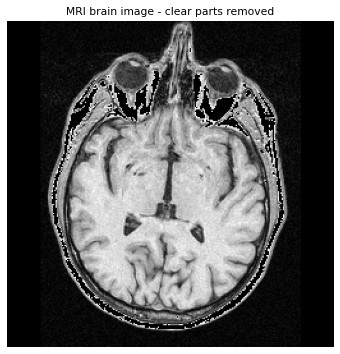

In [23]:
import scipy

brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('Original MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

brain_im[brain_im>100] = 0

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image - clear parts removed')
ax.axis('off')
plt.show()

At this point, some parts of the skull have been removed, but the outer part of the head is still present. To remove the outer part, we can, first of all, apply a median filter with a kernel size of 5:

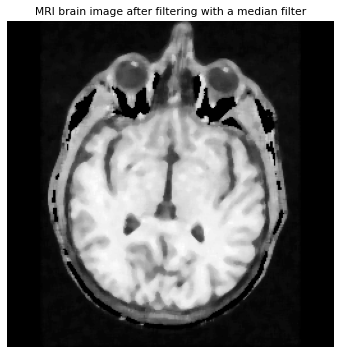

In [24]:
import scipy.signal

brain_im = scipy.signal.medfilt2d(brain_im, kernel_size=5)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image after filtering with a median filter')
ax.axis('off')
plt.show()

After filtering (especially since the kernel is quite big), the image became blurry, but this is not an issue for the current application as the brain is still well distinguishable from the rest. At this point, as we want to get rid of the remaining parts of the skull, the eyes, the nose and everything that surrounds the brain, we can apply erosion twice:

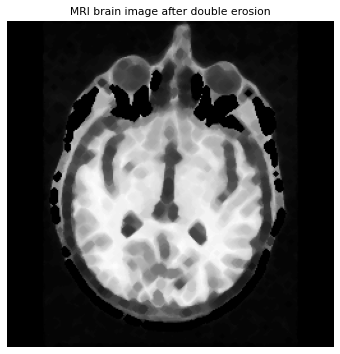

In [25]:
brain_im = skimage.morphology.erosion(brain_im, footprint=None, out=None, shift_x=False, shift_y=False)
brain_im = skimage.morphology.erosion(brain_im, footprint=None, out=None, shift_x=False, shift_y=False)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image after double erosion')
ax.axis('off')
plt.show()

The result is quite satisfactory, and at this point, the brain seems to have a brighter colour with respect to all the remaining parts. Therefore, it should be possible to extract the pixels composing the brain using a threshold. To check which threshold allows to obtain better results, we may try many of them:

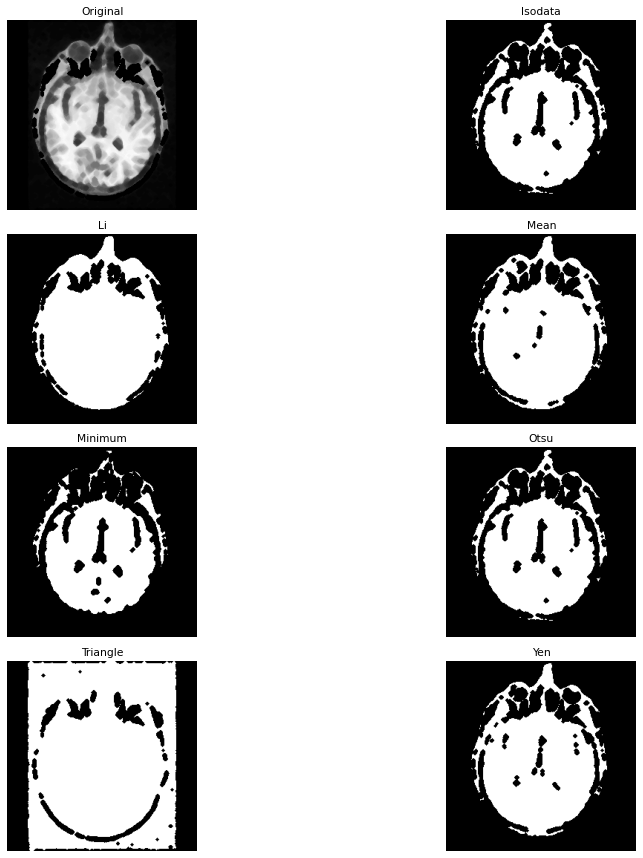

In [26]:
from skimage.filters import try_all_threshold

# Apply many thresholds to the image
fig, ax = try_all_threshold(brain_im, figsize=(16, 12), verbose=False)
plt.show()

The minimum thresholding method allows to obtain very good results and, in particular, disconnects the brain from the rest of the image. We, therefore, decide to use the minimum thresholding method:

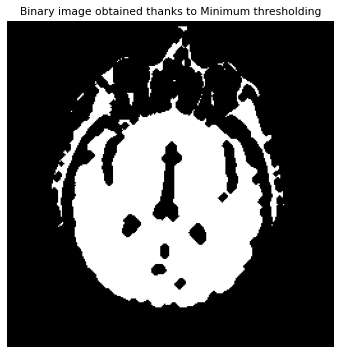

In [27]:
from skimage.filters import threshold_minimum

thresh = threshold_minimum(brain_im)
binary = brain_im > thresh

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(binary, cmap='gray')
ax.set_title('Binary image obtained thanks to Minimum thresholding')
ax.axis('off')
plt.show()

At this point, we may use an area opening to remove everything that is not part of the brain, taking into account that the area of the brain is much bigger than the area of all the other remaining parts. Therefore, the area_threshold parameter is chosen so that the brain is kept and all the other parts are removed.

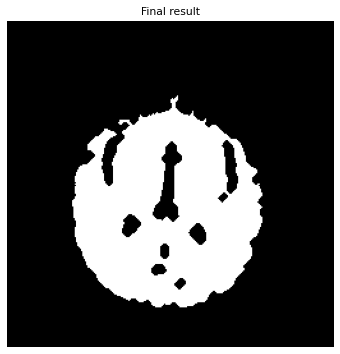

In [28]:
binary = skimage.morphology.area_opening(binary, area_threshold=1000, connectivity=1)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(binary, cmap='gray')
ax.set_title('Final result')
ax.axis('off')
plt.show()

At this point, we can easily measure the size (in pixel) of the brain:

In [29]:
import numpy as np

percentage = np.sum(binary) * 100 / (binary.shape[0]
        * binary.shape[1])
print ('Number of brain pixels:', np.sum(binary), 'Percentage:',
       f"{np.round(percentage, 2)}%")

Number of brain pixels: 15934 Percentage: 24.31%


A concern regarding this approach may be that the whole algorithm has been carefully tuned to work on the image given. To demonstrate that the algorithm is quite robust and that the physical assumptions are indeed valid when considering MRI images, we considered another image taken from the internet (Ptrump16, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, Wikimedia Commons) and we processed it using the same algorithm, without changing any of the parameters identified before.

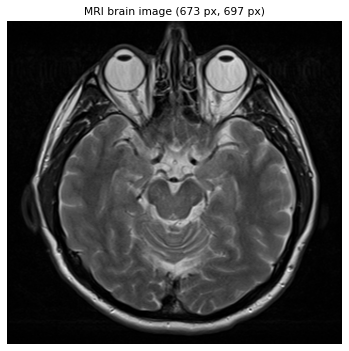

In [30]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice.jpg'))
# Rescaling the values from 0 to 255
brain_im = skimage.color.rgb2gray(brain_im)*255
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

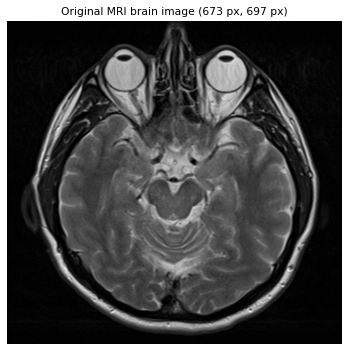

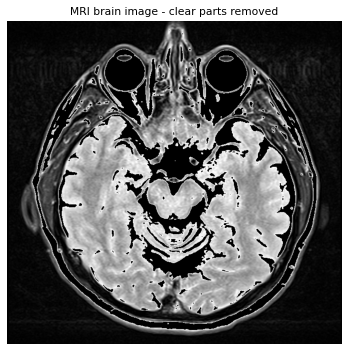

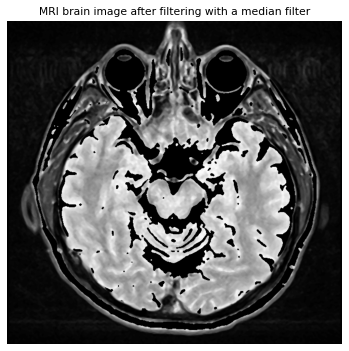

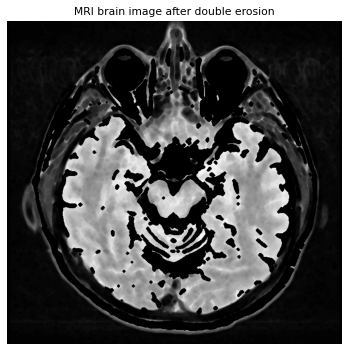

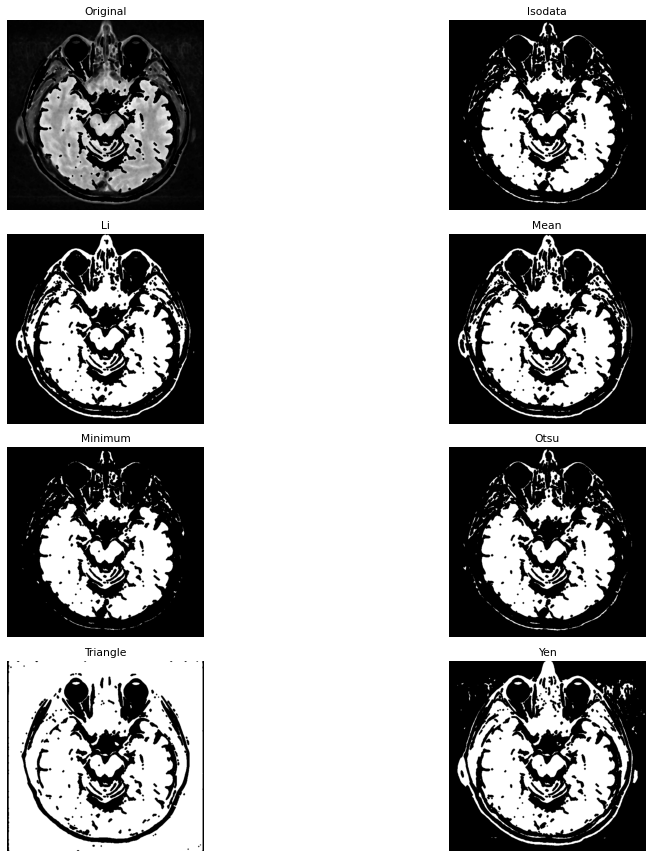

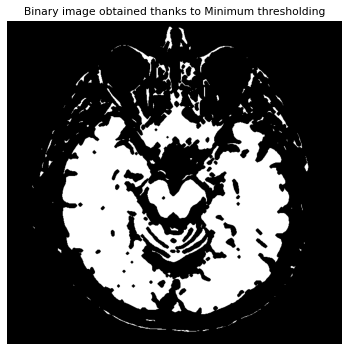

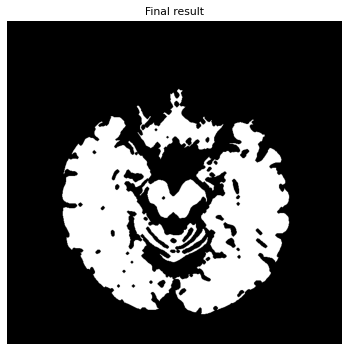

Number of brain pixels: 113585 Percentage: 24.21%


In [31]:
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('Original MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

brain_im[brain_im>100] = 0

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image - clear parts removed')
ax.axis('off')
plt.show()


brain_im = scipy.signal.medfilt2d(brain_im, kernel_size=5)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image after filtering with a median filter')
ax.axis('off')
plt.show()


brain_im = skimage.morphology.erosion(brain_im, footprint=None, out=None, shift_x=False, shift_y=False)
brain_im = skimage.morphology.erosion(brain_im, footprint=None, out=None, shift_x=False, shift_y=False)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image after double erosion')
ax.axis('off')
plt.show()


# Apply many thresholds to the image
fig, ax = try_all_threshold(brain_im, figsize=(16, 12), verbose=False)
plt.show()


thresh = threshold_minimum(brain_im)
binary = brain_im > thresh

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(binary, cmap='gray')
ax.set_title('Binary image obtained thanks to Minimum thresholding')
ax.axis('off')
plt.show()


binary = skimage.morphology.area_opening(binary, area_threshold=1000, connectivity=1)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(binary, cmap='gray')
ax.set_title('Final result')
ax.axis('off')
plt.show()


percentage = np.sum(binary) * 100 / (binary.shape[0]
        * binary.shape[1])
print ('Number of brain pixels:', np.sum(binary), 'Percentage:',
       f"{np.round(percentage, 2)}%")

Although the result is not perfect, it is satisfactory and proves that the algorithm is quite robust and that the assumptions made are reasonable. When analysing this result, we have to consider that the images are very different and are almost surely taken with different MRI machines. If we had to process a large number of pictures taken using the same model of the MRI machine, the threshold values and the assumptions made would lead to an even more precise result.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [32]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


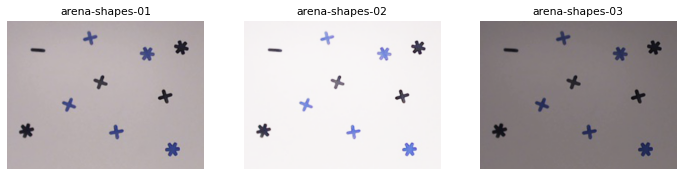

In [33]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

First of all, it is necessary to preprocess the images so that the algorithms that we will implement to count the number of shapes of each color and to compute the total area of each color are robust to illumination changes.
The steps of the preprocessing phase are as follows:
1) Since the RGB color space is not optimal, we use HSV or LAB color spaces;  
2) We consider only one of the three channels of the image in the HSV or LAB color spaces;  
3) We consider the obtained image as a grayscale image.  

We have observed that the best results are obtained in two different situations:
- Considering the HSV color space and the third channel (V);  
- Considering the LAB color space and the first channel (L).  

The second option (LAB color space) yields better results in the following steps of algorithms, and we, therefore, decided to use it. The following cell code executes the procedure detailed and displays the three grayscale images obtained after processing the images.

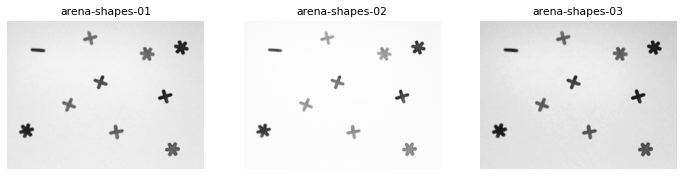

In [34]:
import skimage.color
from skimage import exposure

# Convert the images from the RGB color space to the LAB color space
images_lab = skimage.color.rgb2lab(images)

# Consider only the first channel (L) of the three images in the LAB color space
images_gray = images_lab[:,:,:,0]

# Plot the three images (that are now composed of a single channel) considering them as grayscale images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_gray, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

An interesting option is to use a median filter, as it seems to make the three images more similar (the illumination changes is less evident). Unfortunately, this has a drawback: it has been observed that this unnaturally modifies the size of the objects (especially for the image 'arena-shapes-02'). In the following cell code, we filter the images, and we display the resulting images. Due to the unwanted size modification, we will consider the unfiltered images in the following.

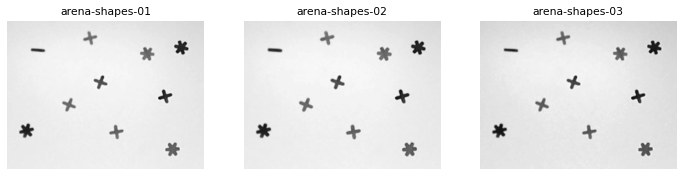

In [35]:
# Apply a median filter to the three images
images_gray_filtered = skimage.filters.median(images_gray)

# Plot the three filtered images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_gray_filtered, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

Once we obtain the grayscale images, we apply a threshold to separate the foreground (objects of different colours and shapes) and the background. The issue here is that the objects have different grayscale values, but they should all be recognized as foreground.

Scikit-image offers different thresholding options, and in order to understand which thresholding method yields the best results, it is possible to test many of them on the same image. We start considering the first image (arena-shapes-01 in the unfiltered version).

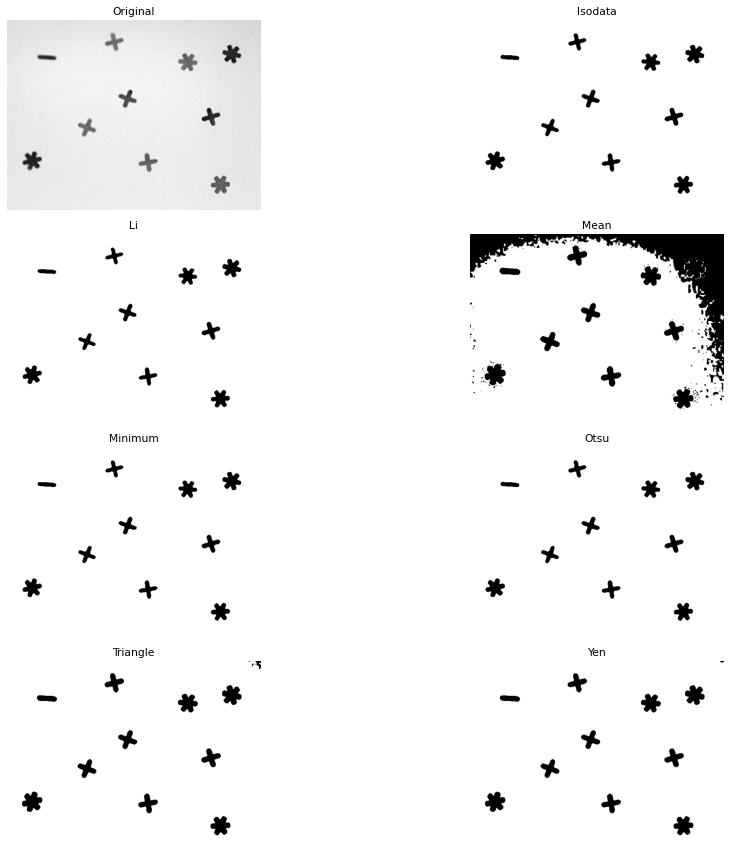

In [36]:
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

# Consider the first image
img = images_gray[0]

# Apply many thresholds to the image
fig, ax = try_all_threshold(img, figsize=(16, 12), verbose=False)
plt.show()

We then consider the second image (arena-shapes-02), unfiltered:

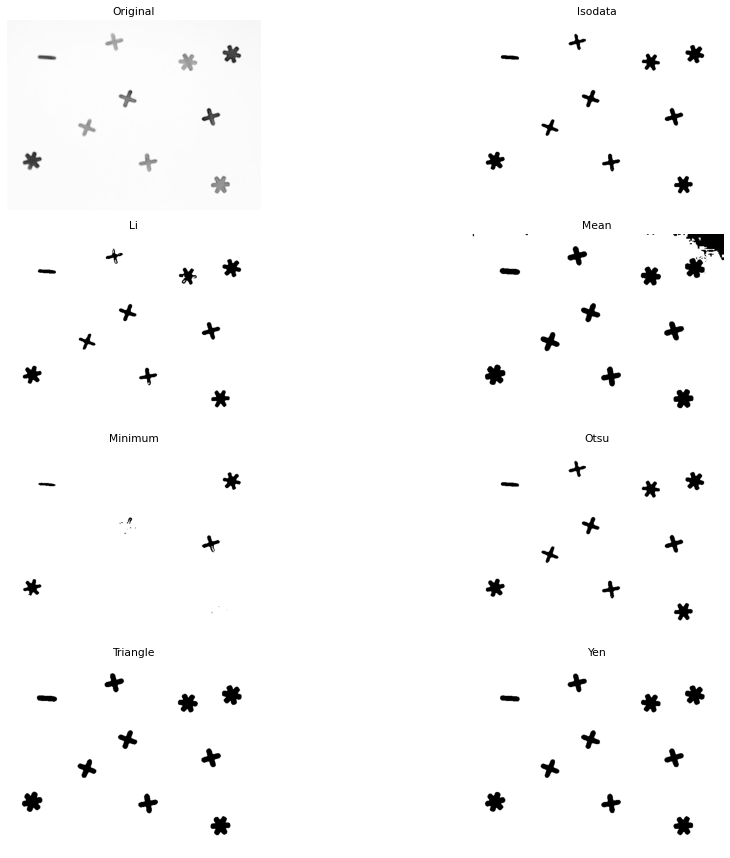

In [37]:
# Consider the second image
img = images_gray[1]

# Apply many thresholds to the image
fig, ax = try_all_threshold(img, figsize=(16, 12), verbose=False)
plt.show()

Then the third image (arena-shapes-03), unfiltered:

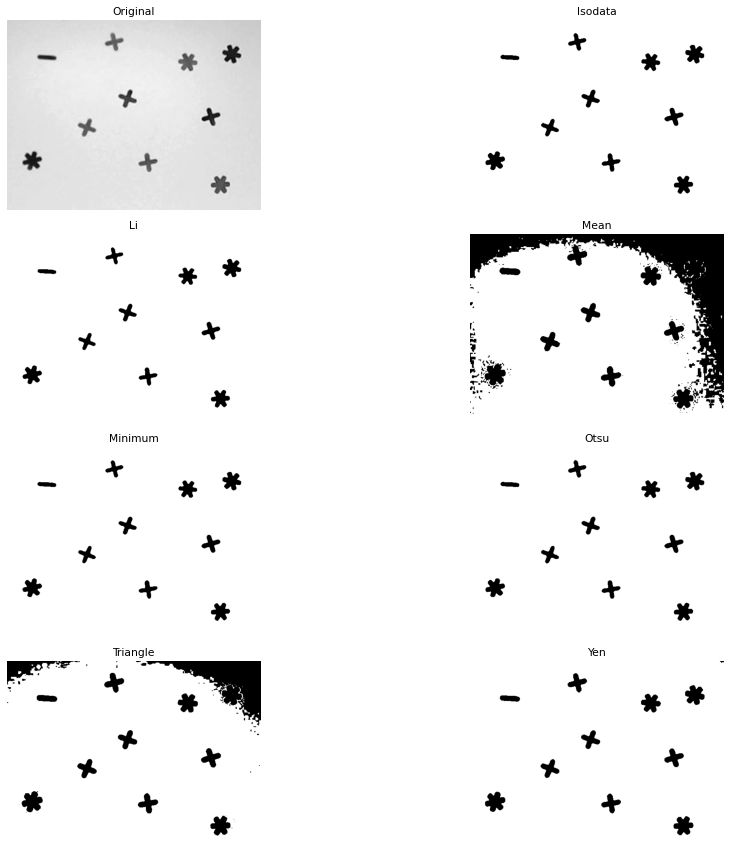

In [38]:
# Consider the third image
img = images_gray[2]

# Apply many thresholds to the image
fig, ax = try_all_threshold(img, figsize=(16, 12), verbose=False)
plt.show()

After considering all the results for the three different images, it is possible to notice that two thresholding methods allow obtaining a correct image segmentation:
- Isodata;
- Otsu.

The Yen thresholding method would allow obtaining very satisfying results, but unfortunately, some pixels in the top-right corner are detected as an object, making it impossible to use the Yen thresholding value found. Nevertheless, we will show later that by changing this threshold by a very low amount (subtracting 1 from the thresholds found for the three images), we obtain excellent results.

At this point, we can start performing the segmentation (using one of the two thresholding methods identified before) in order to separate the foreground from the background. In the following, we will consider the Otsu thresholding method, and we will consider the three unfiltered images. In the cell code below, we start displaying the three grayscale images side by side.

As detailed by the scikit-image guide, the Otsu thresholding method "calculates an “optimal” threshold [...] by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance".

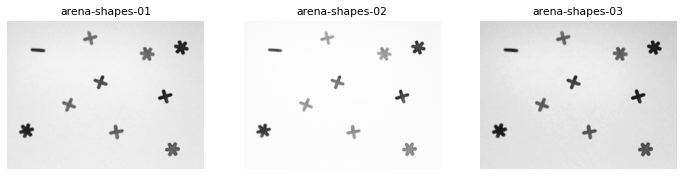

In [39]:
import numpy as np

# Plot the three grayscale images side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_gray, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We then consider the first image (arena-shapes-01), and we apply the Otsu thresholding method. The following cell code displays the original image and the histogram of the original image. It then selects a threshold based on the threshold method and displays the thresholded image. The threshold line is also visible on the histogram.

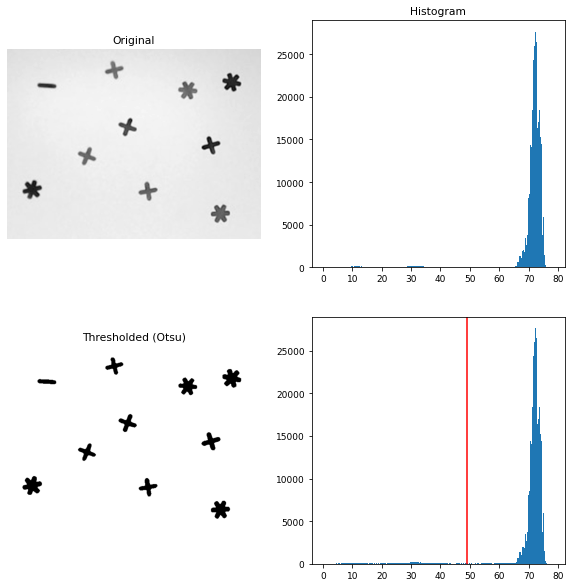

In [40]:
from skimage.filters import threshold_otsu

# Consider the first image
image_used = images_gray[0]

# Select a threshold based on the Otsu thresholding method
thresh_otsu_0 = threshold_otsu(image_used)
binary_otsu = image_used > thresh_otsu_0

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu_0, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

We repeat the same procedure for the second unfiltered image (arena-shapes-02):

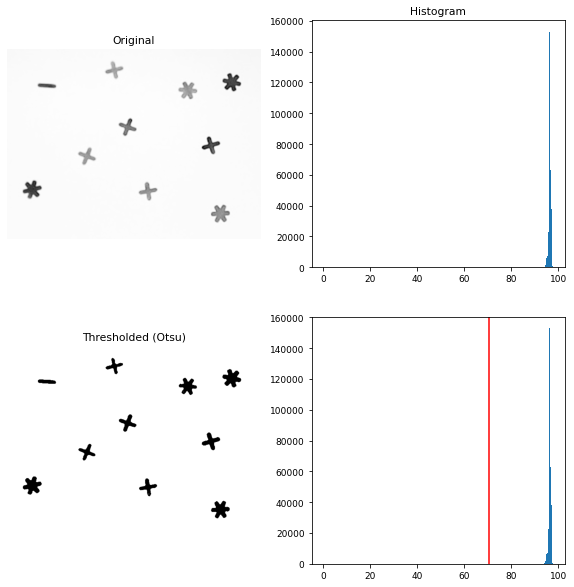

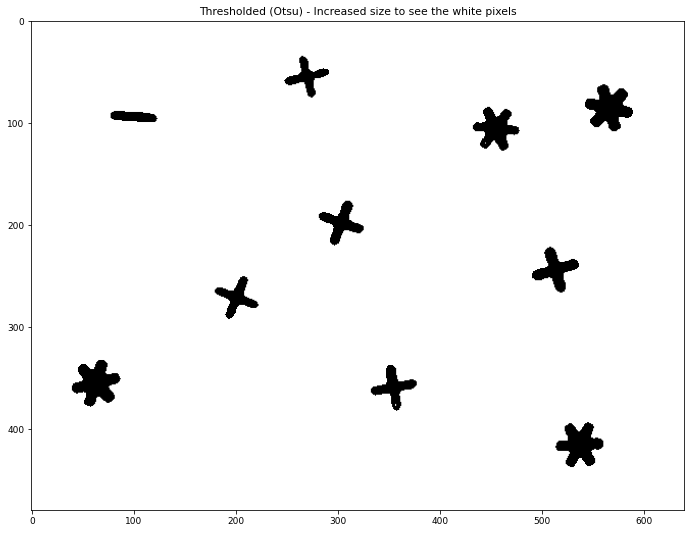

In [41]:
# Consider the second image
image_used = images_gray[1]

# Select a threshold based on the Otsu thresholding method
thresh_otsu_1 = threshold_otsu(image_used)
binary_otsu = image_used > thresh_otsu_1

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu_1, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

plt.figure(figsize=(15, 9))
plt.imshow(binary_otsu, cmap=plt.cm.gray)
plt.title('Thresholded (Otsu) - Increased size to see the white pixels')
plt.show()

In this case, due to the brightness of the original image and due to the fact that some pixels of the objects are unnaturally clearer than the rest of the object (see the image below, pixels circled in red), some pixels inside the objects are recognized as part of the background.
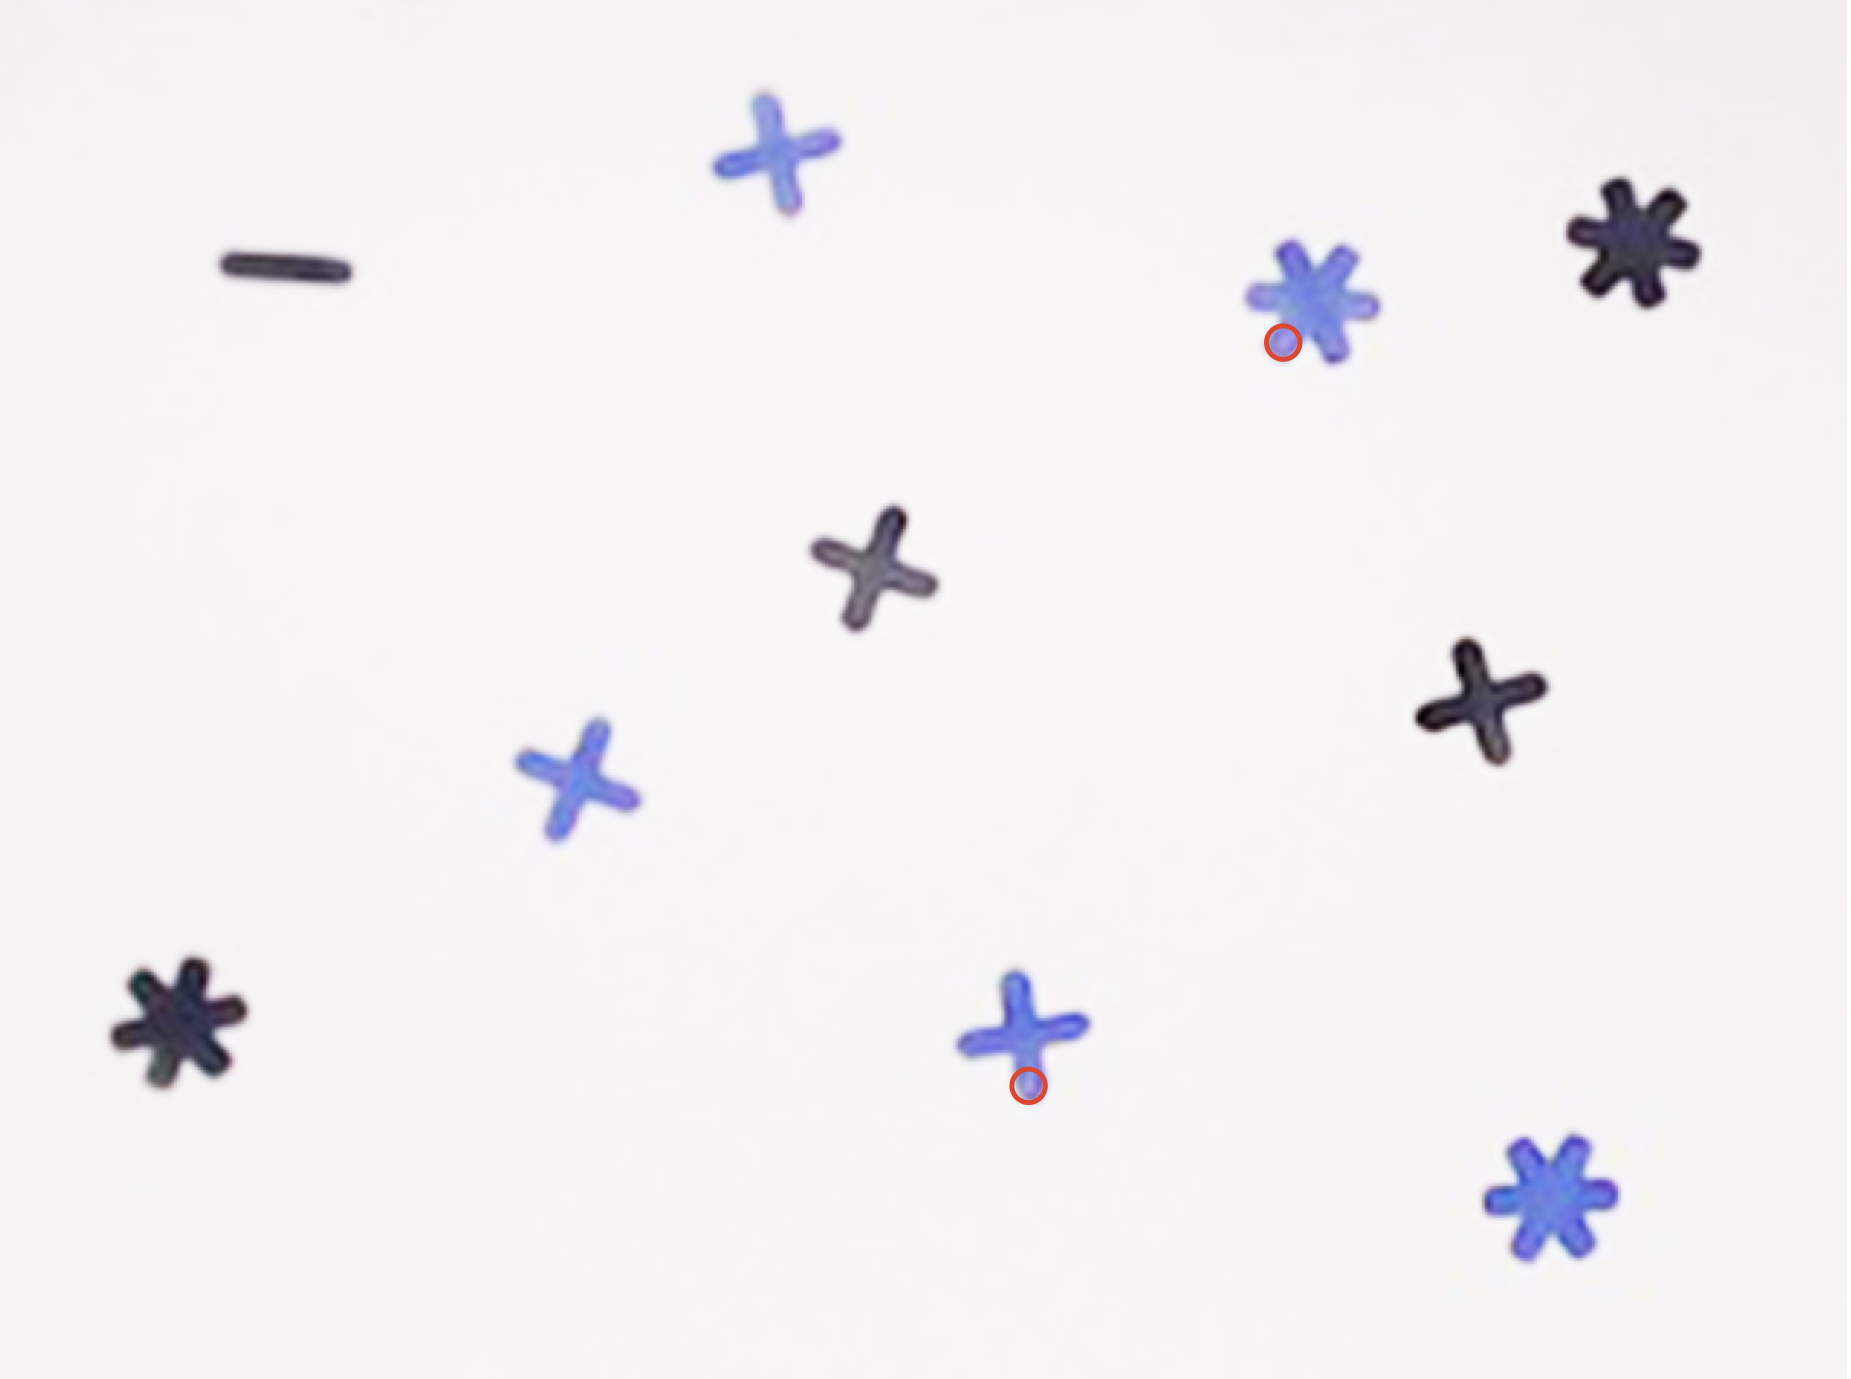
This can be seen, for example, in the plotted image above, and in particular in the lowest '+' object in the image. To solve this, we can use area opening, that as the Scikit guide explains, "removes all bright structures of an image with a surface smaller than area_threshold". We can apply the area opening function to the grayscale image and compute a new threshold based on the processed image. As the image below shows, the white pixels inside the objects are removed.

A side note:
- In principle, we can apply area opening to the other two images (arena-shapes-01 and arena-shapes-03), and if we had to implement an automatic system, we would have done that to make the procedure as independent as possible from the lightning conditions. Here we do not do that just to avoid an unnecessary step.

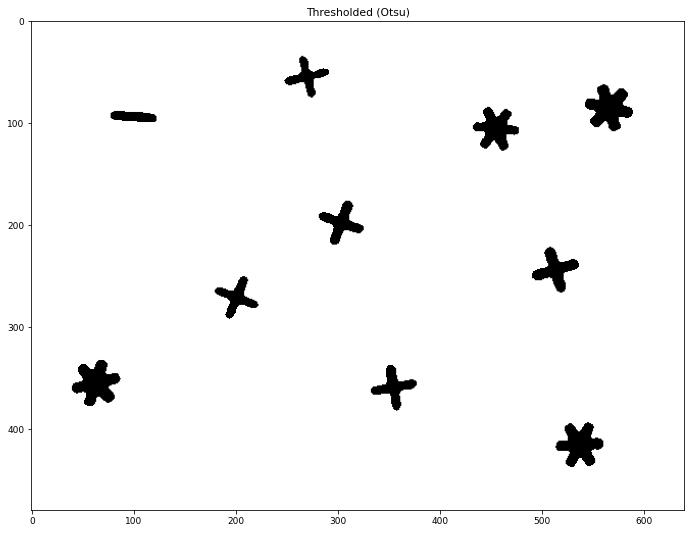

In [42]:
import skimage.morphology

# Apply area opening
image_used = skimage.morphology.area_opening(image_used)

# Recompute the threshold based on the processed image 
thresh_otsu_1 = threshold_otsu(image_used)
binary_otsu = image_used > thresh_otsu_1

plt.figure(figsize=(15, 9))
plt.imshow(binary_otsu, cmap=plt.cm.gray)
plt.title('Thresholded (Otsu)')
plt.show()

And we finally repeat the procedure for the third filtered image (arena-shapes-03):

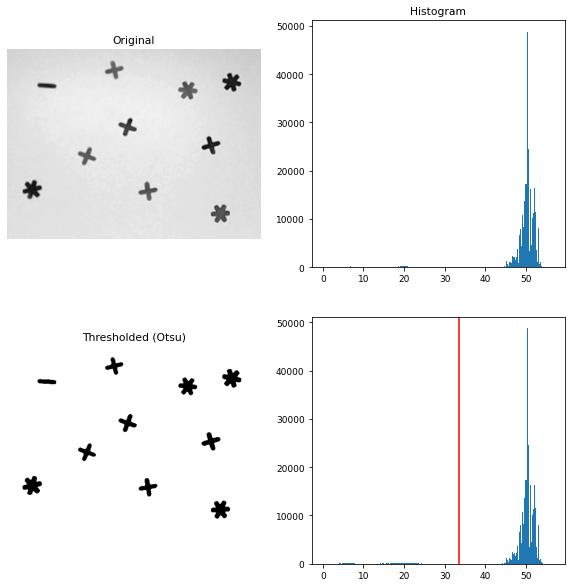

In [43]:
# Consider the third image
image_used = images_gray[2]

# Select a threshold based on the Otsu thresholding method
thresh_otsu_2 = threshold_otsu(image_used)
binary_otsu = image_used > thresh_otsu_2

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Otsu)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_otsu_2, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

At this point, we introduce one of the core algorithms used to solve the problem, whose aim is to build a matrix (of the same size of the image, considering the number of pixels). Using a recursive procedure, the matrix will be filled as follows:
- If the algorithm has not yet decided whether a pixel belongs to the background or to the foreground, the corresponding item in the matrix will be set to 0 (at the beginning of the algorithm, the matrix is filled with zeros);
- If a pixel belongs to the background, the corresponding item in the matrix will be set to -1;
- If a pixel belongs to the foreground, that is, to one of the objects, the corresponding item in the matrix will be set to a value greater than or equal to 1. In particular, the item will indicate the numerical ID of the objects (e.g. all the items corresponding to pixels of the first objects will be set to 1).

The algorithm (implemented in a function called mark_id) works as follows:
- It starts from a given pixel, identified by the indices i and j passed as parameters;
- It checks whether the matrix item indexed by (i, j) exists and is yet to check. If one of these conditions fails, the algorithm does not proceed further;
- It checks, considering the threshold computed before, whether the pixel belongs to the background. If it does, it assigns the value -1 to the corresponding item in the matrix. If instead, the pixel belongs to one of the objects, it assigns the ID number to the corresponding item in the matrix (the current ID is passed as a parameter to the function), and it recursively checks the four adjacent pixels.

In [44]:
def mark_id(image_gray, i, j, object_id, actual_id, thresh):
    if (i<0 or j<0 or i>=image_gray.shape[0] or j>=image_gray.shape[1] or object_id[i, j] != 0):
        return
    if (image_gray[i, j] > thresh):
        object_id[i, j] = -1
    else:
        object_id[i, j] = actual_id
        mark_id(image_gray, i-1, j, object_id, actual_id, thresh)
        mark_id(image_gray, i+1, j, object_id, actual_id, thresh)
        mark_id(image_gray, i, j-1, object_id, actual_id, thresh)
        mark_id(image_gray, i, j+1, object_id, actual_id, thresh)

We now execute the algorithm on the first unfiltered image (arena-shapes-01). The matrix described above is called 'object_id_0' and is initialized to zero values, and the object id ('actual_id') is initialized to 1. Just to have a visual idea of the performance of the algorithm, we can plot the matrix at the end of the algorithm: the background will be displayed as black, and each object is represented using a different grayscale value (uniform throughout the object).

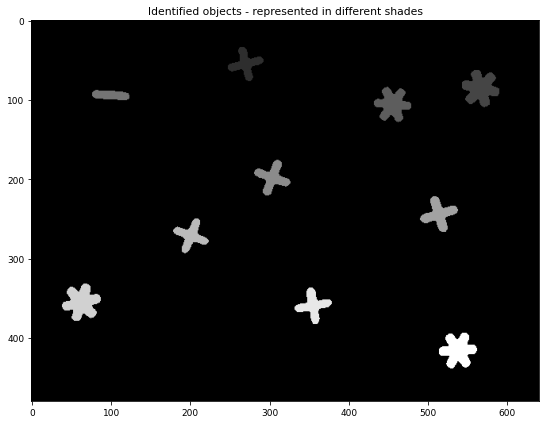

In [45]:
# We consider the first image
image_used = images_gray[0]
object_id_0 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_0, actual_id, thresh_otsu_0)
        if (object_id_0[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_0, cmap='gray')
plt.title('Identified objects - represented in different shades')
plt.show()

We then execute the algorithm on the second unfiltered image (arena-shapes-02). The matrix in this case is called 'object_id_1'.

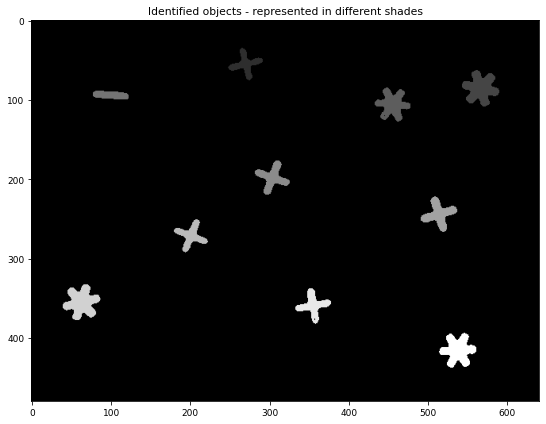

In [46]:
# We consider the second image
image_used = images_gray[1]
object_id_1 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_1, actual_id, thresh_otsu_1)
        if (object_id_1[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_1, cmap='gray')
plt.title('Identified objects - represented in different shades')
plt.show()

We finally execute the algorithm on the third unfiltered image (arena-shapes-03). The matrix in this case is called 'object_id_2'.

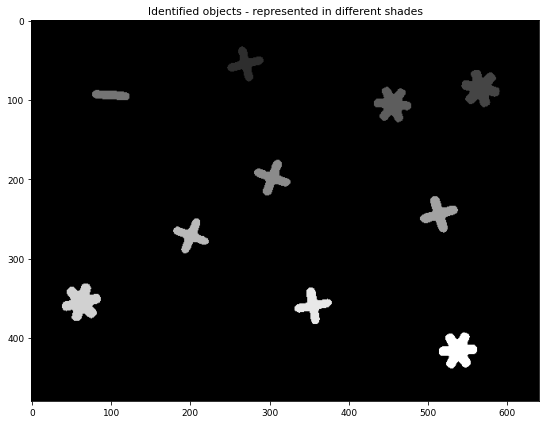

In [47]:
# We consider the third image
image_used = images_gray[2]
object_id_2 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_2, actual_id, thresh_otsu_2)
        if (object_id_2[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_2, cmap='gray')
plt.title('Identified objects - represented in different shades')
plt.show()

At this point, in order to determine the number of objects of each color, we have to identify a new threshold. In order to do so, we consider the original RGB images again (arena-shapes-01, arena-shapes-02, arena-shapes-03), and we extract the blue channel (optimal solution as some of the images are blue). We then consider all the pixels that belong to the objects (that can be easily obtained from the matrices object_id_n, imposing the condition object_id_n > 0. We apply a thresholding method (Otsu) on the extracted object pixels in order to find the threshold that separates the black pixels from the blue pixels. We start obtaining the color threshold for the first image (arena-shapes-01), and we display the histogram (considering only the pixels of the objects) with and without the identified threshold.

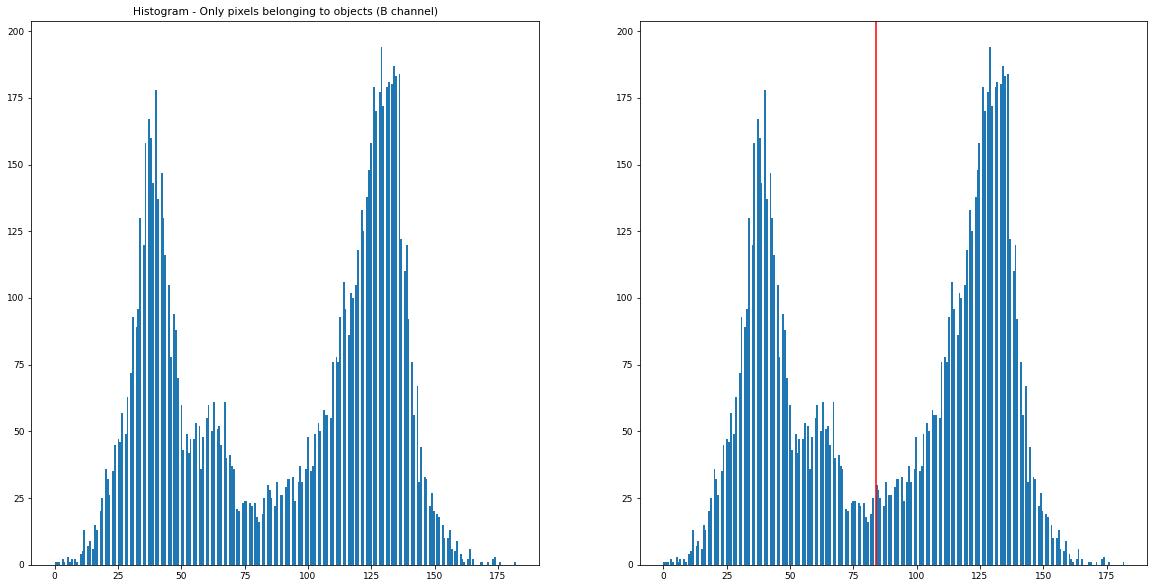

In [48]:
# We consider the 'B' channel of the first image
B_image = images[0,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_0 = threshold_otsu(B_image[object_id_0 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_0 > 0].ravel(), bins=256)
ax[0].set_title('Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_0 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_0, color='r')

We then repeat the procedure for the second image (arena-shapes-02):

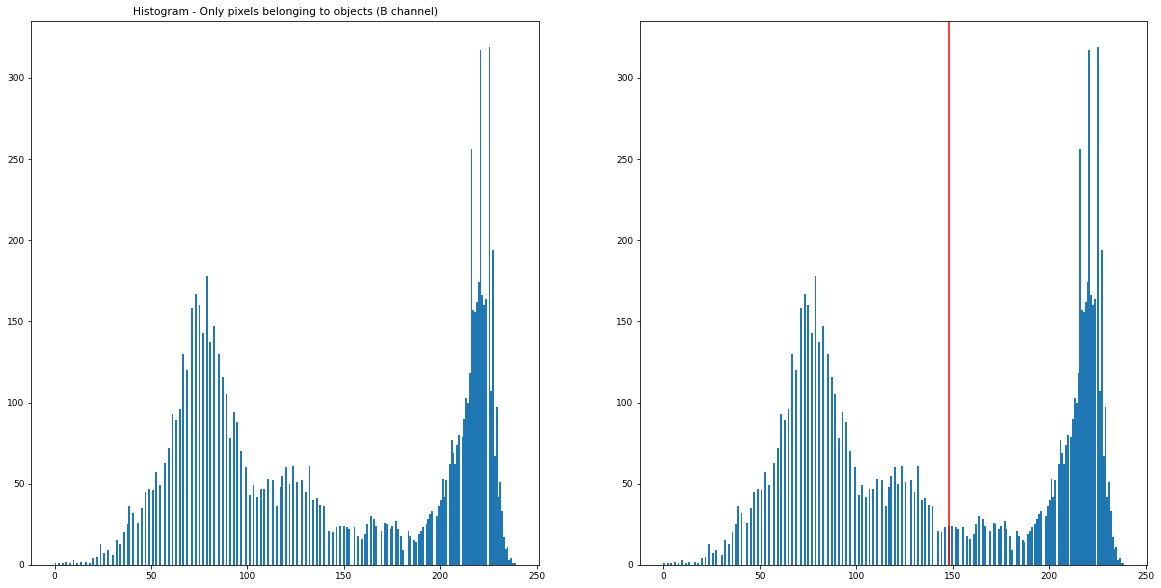

In [49]:
# We consider the 'B' channel of the second image
B_image = images[1,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_1 = threshold_otsu(B_image[object_id_1 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_1 > 0].ravel(), bins=256)
ax[0].set_title('Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_1 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_1, color='r')

And we finally repeat the procedure considering the third image (arena-shapes-03):

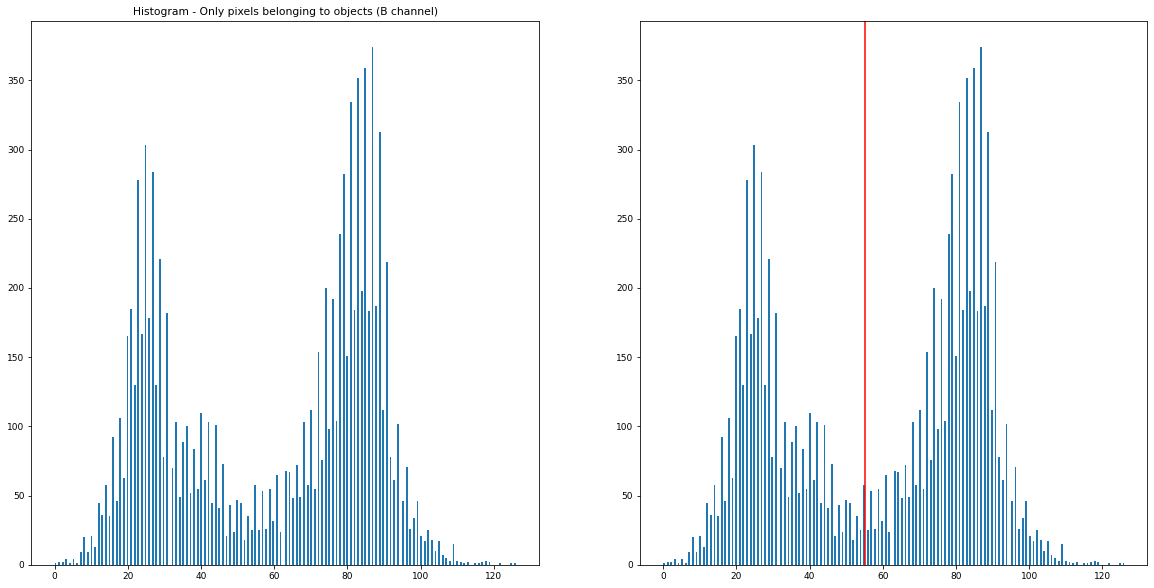

In [50]:
# We consider the 'B' channel of the third image
B_image = images[2,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_2 = threshold_otsu(B_image[object_id_2 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_2 > 0].ravel(), bins=256)
ax[0].set_title('Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_2 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_2, color='r')

Once obtained the three thresholds, it is possible to decide whether each of the objects is blue or black. Note that it is possible that some pixels of a black object will be classified as blue, and vice versa, as the colors are not completely uniforms. Indeed, as we can observe in the histograms, we do not have two peaks, but the colours are more distributed (according to a distribution approximately normal).

To decide whether each object is black or blue, we use a majority vote: if the majority of the pixels of an object are classified of a certain color (according to the threshold identified before), the object is classified as being of that given color. Note that we are also computing the sizes, in pixels, of the objects, which will be useful to solve the second part of the exercise.

We start considering the first image (arena-shapes-01):

In [51]:
# We consider the 'B' channel of the first image
B_image = images[0,:,:,2]

sizes_0 = np.zeros((np.unique(object_id_0)).size - 1)
above_or_under_0 = np.zeros((np.unique(object_id_0)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_0.shape[0]):
    for j in range(object_id_0.shape[1]):
        if (object_id_0[i, j] != -1):
            sizes_0[object_id_0[i, j].astype(int) - 1] = sizes_0[object_id_0[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_0):
                above_or_under_0[object_id_0[i, j].astype(int) - 1] = above_or_under_0[object_id_0[i, j].astype(int) - 1] + 1
            else:
                above_or_under_0[object_id_0[i, j].astype(int) - 1] = above_or_under_0[object_id_0[i, j].astype(int) - 1] - 1
            
print("Sizes of the objects (in pixels): ", sizes_0)

num_blue_0 = 0
num_black_0 = 0

for i in range(np.unique(object_id_0).size - 1):
    if (above_or_under_0[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_0 = num_blue_0 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_0 = num_black_0 + 1
        
print("Number of blue objects: ", num_blue_0)
print("Number of black objects: ", num_black_0)

Sizes of the objects (in pixels):  [ 780. 1350. 1197.  476.  875.  937.  815. 1360.  848. 1303.]
Object  0 is of blue color
Object  1 is of black color
Object  2 is of blue color
Object  3 is of black color
Object  4 is of black color
Object  5 is of black color
Object  6 is of blue color
Object  7 is of black color
Object  8 is of blue color
Object  9 is of blue color
Number of blue objects:  5
Number of black objects:  5


We then repeat the same procedure for the second image (arena-shapes-02):

In [52]:
# We consider the 'B' channel of the second image
B_image = images[1,:,:,2]

sizes_1 = np.zeros((np.unique(object_id_1)).size - 1)
above_or_under_1 = np.zeros((np.unique(object_id_1)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_1.shape[0]):
    for j in range(object_id_1.shape[1]):
        if (object_id_1[i, j] != -1):
            sizes_1[object_id_1[i, j].astype(int) - 1] = sizes_1[object_id_1[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_1):
                above_or_under_1[object_id_1[i, j].astype(int) - 1] = above_or_under_1[object_id_1[i, j].astype(int) - 1] + 1
            else:
                above_or_under_1[object_id_1[i, j].astype(int) - 1] = above_or_under_1[object_id_1[i, j].astype(int) - 1] - 1
            
print("Sizes of the objects (in pixels): ", sizes_1)

num_blue_1 = 0
num_black_1 = 0

for i in range(np.unique(object_id_1).size - 1):
    if (above_or_under_1[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_1 = num_blue_1 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_1 = num_black_1 + 1
        
print("Number of blue objects: ", num_blue_1)
print("Number of black objects: ", num_black_1)

Sizes of the objects (in pixels):  [ 598. 1234. 1026.  396.  761.  843.  663. 1221.  714. 1167.]
Object  0 is of blue color
Object  1 is of black color
Object  2 is of blue color
Object  3 is of black color
Object  4 is of black color
Object  5 is of black color
Object  6 is of blue color
Object  7 is of black color
Object  8 is of blue color
Object  9 is of blue color
Number of blue objects:  5
Number of black objects:  5


We finally repeat the same procedure for the third image (arena-shapes-03):

In [53]:
# We consider the 'B' channel of the third image
B_image = images[2,:,:,2]

sizes_2 = np.zeros((np.unique(object_id_2)).size - 1)
above_or_under_2 = np.zeros((np.unique(object_id_2)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_2.shape[0]):
    for j in range(object_id_2.shape[1]):
        if (object_id_2[i, j] != -1):
            sizes_2[object_id_2[i, j].astype(int) - 1] = sizes_2[object_id_2[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_2):
                above_or_under_2[object_id_2[i, j].astype(int) - 1] = above_or_under_2[object_id_2[i, j].astype(int) - 1] + 1
            else:
                above_or_under_2[object_id_2[i, j].astype(int) - 1] = above_or_under_2[object_id_2[i, j].astype(int) - 1] - 1
            
print("Sizes of the objects (in pixels): ", sizes_2)

num_blue_2 = 0
num_black_2 = 0

for i in range(np.unique(object_id_2).size - 1):
    if (above_or_under_2[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_2 = num_blue_2 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_2 = num_black_2 + 1
        
print("Number of blue objects: ", num_blue_2)
print("Number of black objects: ", num_black_2)

Sizes of the objects (in pixels):  [ 814. 1370. 1231.  485.  892.  954.  839. 1390.  869. 1322.]
Object  0 is of blue color
Object  1 is of black color
Object  2 is of blue color
Object  3 is of black color
Object  4 is of black color
Object  5 is of black color
Object  6 is of blue color
Object  7 is of black color
Object  8 is of blue color
Object  9 is of blue color
Number of blue objects:  5
Number of black objects:  5


It is possible to draw some conclusions on the first task, that is, counting the number of shapes of each color. The algorithm presented allows to obtain correct results for the three images: each of the objects is correctly recognized, and the colours are correctly discriminated. Indeed, ten objects are detected in each image (labeled with IDs from 0 to 1), five of blue colour and five of black colour. Furthermore, each object (characterized by the same ID in the three pictures) is recognized to be of the same colour in the three pictures. The algorithm presented, also thanks to the preprocessing steps implemented, are therefore robust to illumination changes as requested.

### 2.3 Total area (in pixels) of each color (5 pts)

We now want to compute the total area (in pixels) of each color. Since we have already computed the size of the objects and we have determined the colour of each object, we can obtain the total area of each color with very simple computations.

In [54]:
# We consider the first image
size_blue_0 = 0
size_black_0 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_0).size - 1):
    if (above_or_under_0[i] > 0):
        size_blue_0 = size_blue_0 + sizes_0[i]
    else:
        size_black_0 = size_black_0 + sizes_0[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-01' = ", size_blue_0)
print("Total area (in pixels) of black color for the image 'arena-shapes-01' = ", size_black_0)


# We consider the second image
size_blue_1 = 0
size_black_1 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_1).size - 1):
    if (above_or_under_1[i] > 0):
        size_blue_1 = size_blue_1 + sizes_1[i]
    else:
        size_black_1 = size_black_1 + sizes_1[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-02' = ", size_blue_1)
print("Total area (in pixels) of black color for the image 'arena-shapes-02' = ", size_black_1)


# We consider the third image
size_blue_2 = 0
size_black_2 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_2).size - 1):
    if (above_or_under_2[i] > 0):
        size_blue_2 = size_blue_2 + sizes_2[i]
    else:
        size_black_2 = size_black_2 + sizes_2[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-03' = ", size_blue_2)
print("Total area (in pixels) of black color for the image 'arena-shapes-03' = ", size_black_2)

Total area (in pixels) of blue color for the image 'arena-shapes-01' =  4943.0
Total area (in pixels) of black color for the image 'arena-shapes-01' =  4998.0
Total area (in pixels) of blue color for the image 'arena-shapes-02' =  4168.0
Total area (in pixels) of black color for the image 'arena-shapes-02' =  4455.0
Total area (in pixels) of blue color for the image 'arena-shapes-03' =  5075.0
Total area (in pixels) of black color for the image 'arena-shapes-03' =  5091.0


Starting from the results obtained, it is possible to draw some conclusions on the second task, that is, computing the total area (in pixels) of each color. The total area computed is not exactly equal for the three images. If we take the first image ('arena-shapes-01') as a reference:
- The total area (in pixels) of blue color for the second image ('arena-shapes-02') is 16% lower: $\frac{4168-4943}{4943} = -0.16 = -16\%$
- The total area (in pixels) of black color for the second image ('arena-shapes-02') is 11% lower: $\frac{4455-4998}{4998} = -0.11 = -11\%$
- The total area (in pixels) of blue color for the third image ('arena-shapes-03') is 2.7% higher: $\frac{5075-4943}{4943} = 0.027 = 2.7\%$
- The total area (in pixels) of black color for the third image ('arena-shapes-03') is 1.9% higher: $\frac{5091-4998}{4998} = 0.019 = 1.9\%$

Considering the first and the third image, we obtain very similar results, but in the second image the computed areas are lower. This is mainly due to two reasons:
1) since the second image is very bright, when we perform the conversion to grayscale images, the objects are in a light-gray shade, and the threshold computed using the Otsu thresholding method erodes some pixels of the objects. This is particularly evident, for example, in the uppermost '+' object;

2) the starting objects appear smaller in the second image than in the other two images. This can be seen considering two regions of equal size (50 x 50 pixels) representing the same object obtained from the images 'arena-shapes-01':
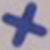

 and 'arena-shapes-02':
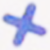
 It is possible to see that the object appears to be thicker in the image 'arena-shapes-01' (this may be due to the brightness modification).

As specified previously, another thresholding method (Yen) seemed to yield very good results, but it has been discarded as some background pixels were interpreted as part of the foreground. However, by performing some experiments, it has been observed that it is sufficient to subtract 1 from the three threshold values (corresponding to the three images) identified by the Yen thresholding method to correct this behaviour. Furthermore, using this method, we can correct some unwanted effects, in particular:
- using the Otsu thresholding method, the objects in the second image were a bit too thin. Using the Yen thresholding method, the objects are detected more accurately;
- using the Otsu thresholding method, it was necessary to use an area opening to remove some white pixels from the objects in the second image. However, using the Yen thresholding method is not necessary anymore.

In the following, we repeat the whole code introduced previously, changing the thresholding method and subtracting 1 to the threshold values identified by the Yen thresholding method. The images produced by the code are the same as before.

Further information about the Yen thresholding method can be found at: https://ieeexplore.ieee.org/document/366472 .

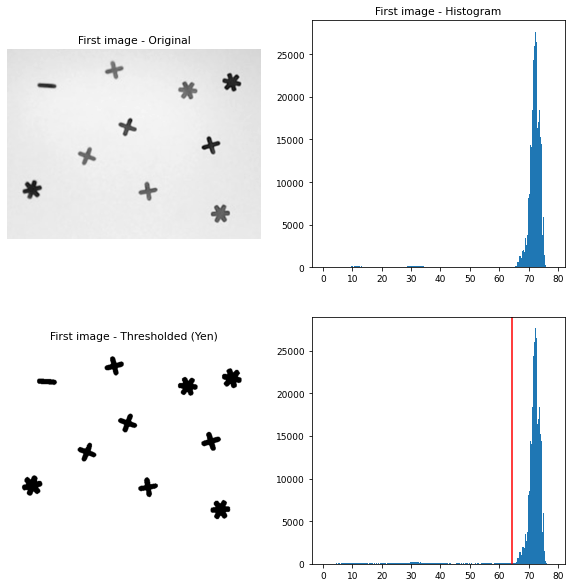

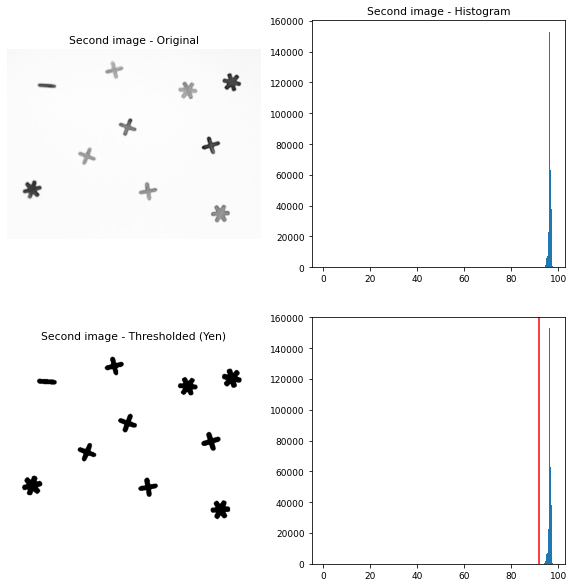

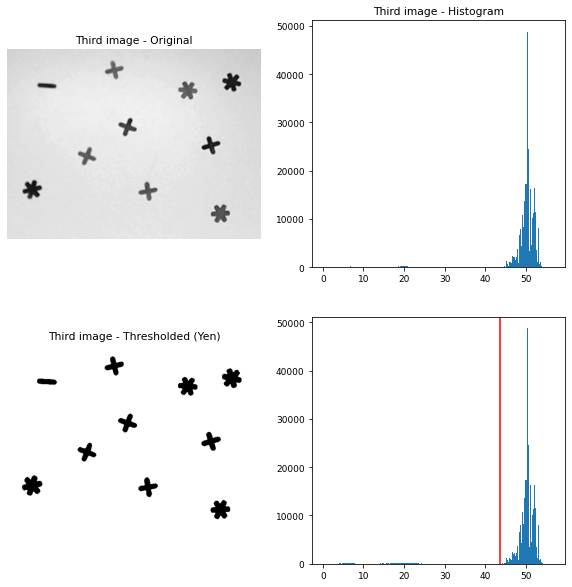

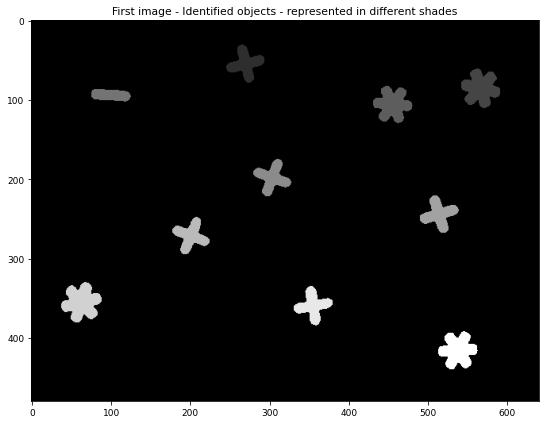

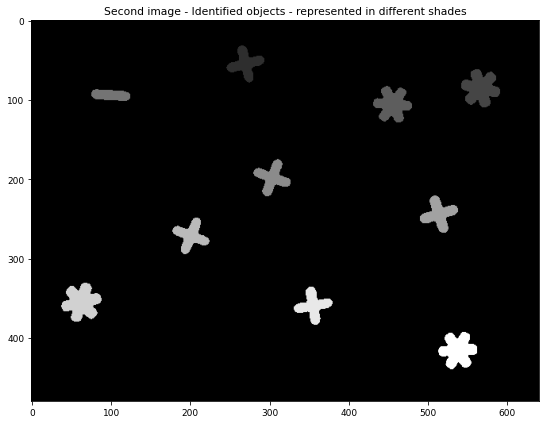

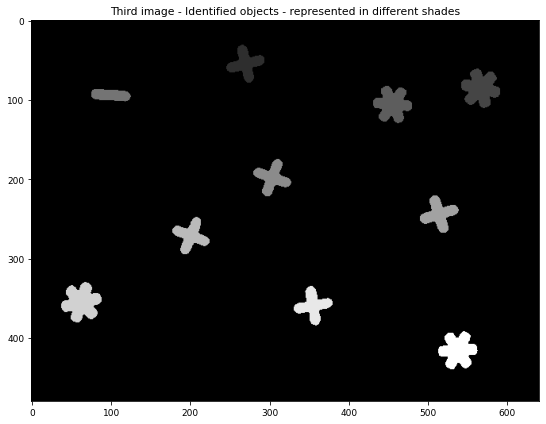

First image - Sizes of the objects (in pixels):  [1050. 1570. 1455.  628. 1047. 1094. 1042. 1629. 1069. 1519.]
Object  0 is of blue color
Object  1 is of black color
Object  2 is of blue color
Object  3 is of black color
Object  4 is of black color
Object  5 is of black color
Object  6 is of blue color
Object  7 is of black color
Object  8 is of blue color
Object  9 is of blue color
First image - Number of blue objects:  5
First image - Number of black objects:  5
Second image - Sizes of the objects (in pixels):  [ 968. 1492. 1377.  580.  995. 1054.  980. 1545. 1003. 1453.]
Object  0 is of blue color
Object  1 is of black color
Object  2 is of blue color
Object  3 is of black color
Object  4 is of black color
Object  5 is of black color
Object  6 is of blue color
Object  7 is of black color
Object  8 is of blue color
Object  9 is of blue color
Second image - Number of blue objects:  5
Second image - Number of black objects:  5
Third image - Sizes of the objects (in pixels):  [1038. 156

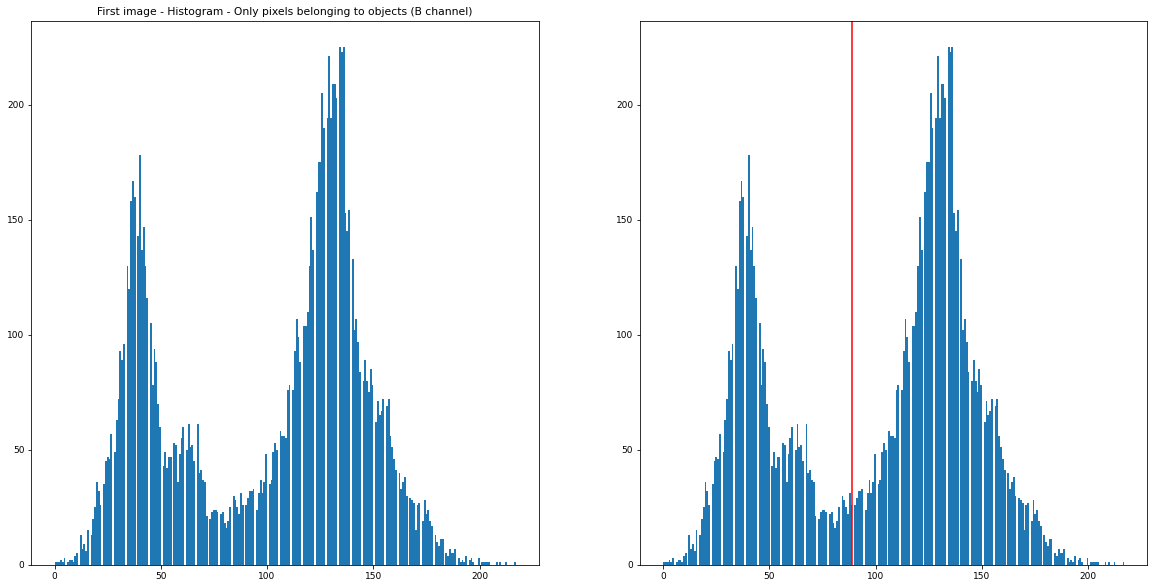

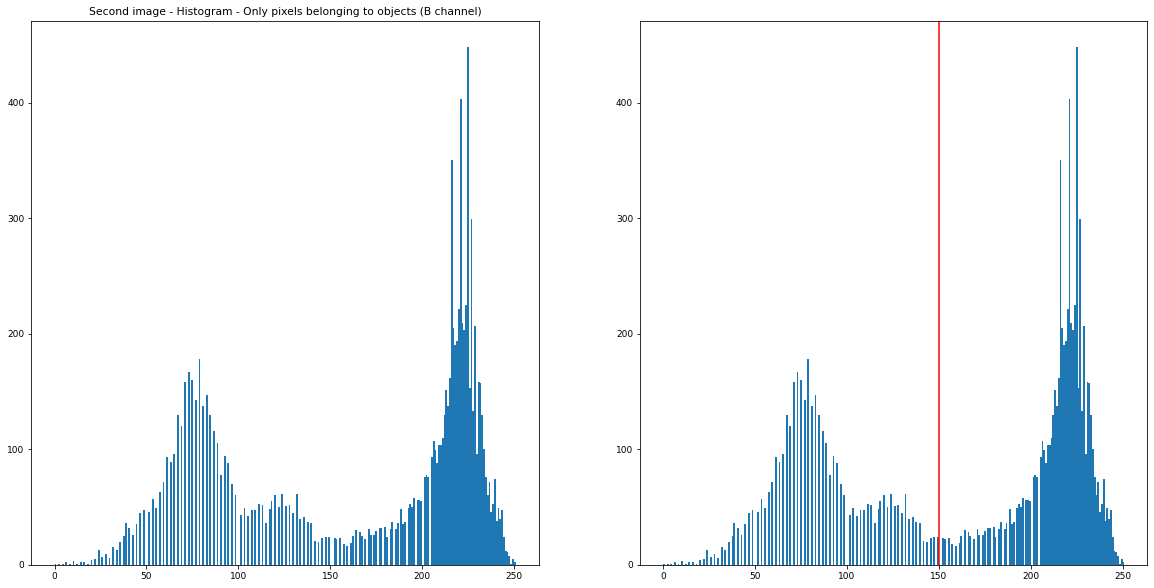

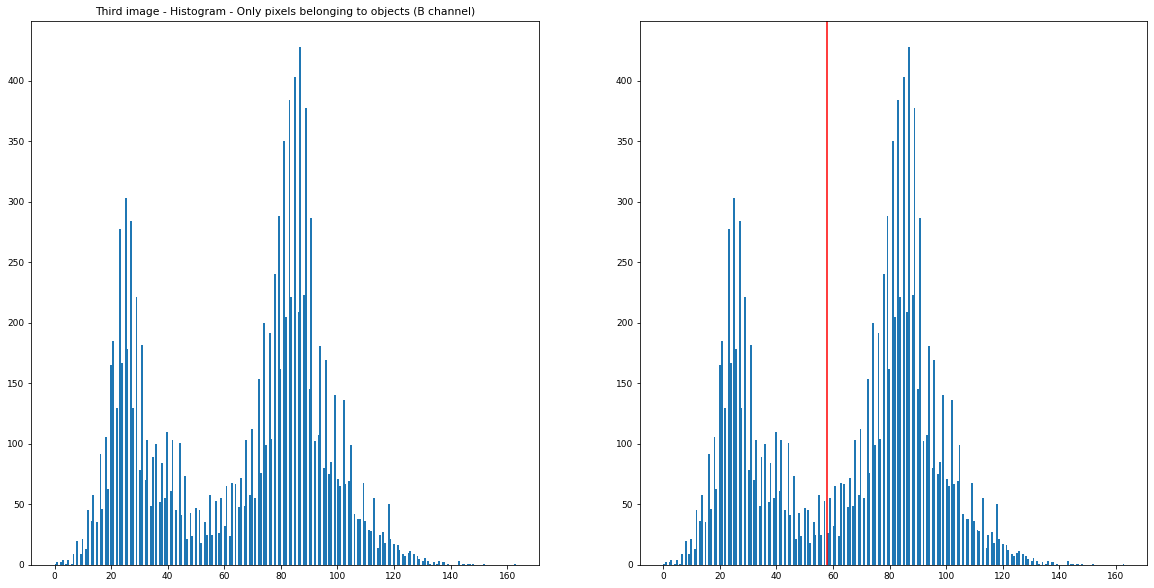

In [55]:
from skimage.filters import threshold_yen

# Consider the first image
image_used = images_gray[0]

# Select a threshold based on the Yen thresholding method
thresh_yen_0 = threshold_yen(image_used) - 1
binary_yen = image_used > thresh_yen_0

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('First image - Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('First image - Histogram')

ax[1, 0].imshow(binary_yen, cmap=plt.cm.gray)
ax[1, 0].set_title('First image - Thresholded (Yen)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_yen_0, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

# Consider the second image
image_used = images_gray[1]

# Select a threshold based on the Yen thresholding method
thresh_yen_1 = threshold_yen(image_used) - 1
binary_yen = image_used > thresh_yen_1

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('Second image - Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('Second image - Histogram')

ax[1, 0].imshow(binary_yen, cmap=plt.cm.gray)
ax[1, 0].set_title('Second image - Thresholded (Yen)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_yen_1, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

# Consider the third image
image_used = images_gray[2]

# Select a threshold based on the Yen thresholding method
thresh_yen_2 = threshold_yen(image_used) - 1
binary_yen = image_used > thresh_yen_2

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image_used, cmap=plt.cm.gray)
ax[0, 0].set_title('Third image - Original')

ax[0, 1].hist(image_used.ravel(), bins=256)
ax[0, 1].set_title('Third image - Histogram')

ax[1, 0].imshow(binary_yen, cmap=plt.cm.gray)
ax[1, 0].set_title('Third image - Thresholded (Yen)')

ax[1, 1].hist(image_used.ravel(), bins=256)
ax[1, 1].axvline(thresh_yen_2, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

# We consider the first image
image_used = images_gray[0]
object_id_0 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_0, actual_id, thresh_yen_0)
        if (object_id_0[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_0, cmap='gray')
plt.title('First image - Identified objects - represented in different shades')
plt.show()

# We consider the second image
image_used = images_gray[1]
object_id_1 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_1, actual_id, thresh_yen_1)
        if (object_id_1[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_1, cmap='gray')
plt.title('Second image - Identified objects - represented in different shades')
plt.show()

# We consider the third image
image_used = images_gray[2]
object_id_2 = np.zeros(image_used.shape)
actual_id = 1

# Procedure to assign IDs the objects in the image
for i in range(image_used.shape[0]):
    for j in range(image_used.shape[1]):
        mark_id(image_used, i, j, object_id_2, actual_id, thresh_yen_2)
        if (object_id_2[i, j] == actual_id):
            actual_id = actual_id + 1
            
plt.figure(figsize=(12, 7))
plt.imshow(object_id_2, cmap='gray')
plt.title('Third image - Identified objects - represented in different shades')
plt.show()

# We consider the 'B' channel of the first image
B_image = images[0,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_0 = threshold_otsu(B_image[object_id_0 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_0 > 0].ravel(), bins=256)
ax[0].set_title('First image - Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_0 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_0, color='r')

# We consider the 'B' channel of the second image
B_image = images[1,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_1 = threshold_otsu(B_image[object_id_1 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_1 > 0].ravel(), bins=256)
ax[0].set_title('Second image - Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_1 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_1, color='r')

# We consider the 'B' channel of the third image
B_image = images[2,:,:,2]

# We determine the threshold that discriminates between blue and black pixels
thresh_col_otsu_2 = threshold_otsu(B_image[object_id_2 > 0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(B_image[object_id_2 > 0].ravel(), bins=256)
ax[0].set_title('Third image - Histogram - Only pixels belonging to objects (B channel)')

ax[1].hist(B_image[object_id_2 > 0].ravel(), bins=256)
ax[1].axvline(thresh_col_otsu_2, color='r')

# We consider the 'B' channel of the first image
B_image = images[0,:,:,2]

sizes_0 = np.zeros((np.unique(object_id_0)).size - 1)
above_or_under_0 = np.zeros((np.unique(object_id_0)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_0.shape[0]):
    for j in range(object_id_0.shape[1]):
        if (object_id_0[i, j] != -1):
            sizes_0[object_id_0[i, j].astype(int) - 1] = sizes_0[object_id_0[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_0):
                above_or_under_0[object_id_0[i, j].astype(int) - 1] = above_or_under_0[object_id_0[i, j].astype(int) - 1] + 1
            else:
                above_or_under_0[object_id_0[i, j].astype(int) - 1] = above_or_under_0[object_id_0[i, j].astype(int) - 1] - 1
            
print("First image - Sizes of the objects (in pixels): ", sizes_0)

num_blue_0 = 0
num_black_0 = 0

for i in range(np.unique(object_id_0).size - 1):
    if (above_or_under_0[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_0 = num_blue_0 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_0 = num_black_0 + 1
        
print("First image - Number of blue objects: ", num_blue_0)
print("First image - Number of black objects: ", num_black_0)

# We consider the 'B' channel of the second image
B_image = images[1,:,:,2]

sizes_1 = np.zeros((np.unique(object_id_1)).size - 1)
above_or_under_1 = np.zeros((np.unique(object_id_1)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_1.shape[0]):
    for j in range(object_id_1.shape[1]):
        if (object_id_1[i, j] != -1):
            sizes_1[object_id_1[i, j].astype(int) - 1] = sizes_1[object_id_1[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_1):
                above_or_under_1[object_id_1[i, j].astype(int) - 1] = above_or_under_1[object_id_1[i, j].astype(int) - 1] + 1
            else:
                above_or_under_1[object_id_1[i, j].astype(int) - 1] = above_or_under_1[object_id_1[i, j].astype(int) - 1] - 1
            
print("Second image - Sizes of the objects (in pixels): ", sizes_1)

num_blue_1 = 0
num_black_1 = 0

for i in range(np.unique(object_id_1).size - 1):
    if (above_or_under_1[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_1 = num_blue_1 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_1 = num_black_1 + 1
        
print("Second image - Number of blue objects: ", num_blue_1)
print("Second image - Number of black objects: ", num_black_1)

# We consider the 'B' channel of the third image
B_image = images[2,:,:,2]

sizes_2 = np.zeros((np.unique(object_id_2)).size - 1)
above_or_under_2 = np.zeros((np.unique(object_id_2)).size - 1)

# We perform a majority vote to assess the colour of each object detected
for i in range(object_id_2.shape[0]):
    for j in range(object_id_2.shape[1]):
        if (object_id_2[i, j] != -1):
            sizes_2[object_id_2[i, j].astype(int) - 1] = sizes_2[object_id_2[i, j].astype(int) - 1] + 1
            if (B_image[i, j] > thresh_col_otsu_2):
                above_or_under_2[object_id_2[i, j].astype(int) - 1] = above_or_under_2[object_id_2[i, j].astype(int) - 1] + 1
            else:
                above_or_under_2[object_id_2[i, j].astype(int) - 1] = above_or_under_2[object_id_2[i, j].astype(int) - 1] - 1
            
print("Third image - Sizes of the objects (in pixels): ", sizes_2)

num_blue_2 = 0
num_black_2 = 0

for i in range(np.unique(object_id_2).size - 1):
    if (above_or_under_2[i] > 0):
        print("Object ", i, "is of blue color")
        num_blue_2 = num_blue_2 + 1
    else:
        print("Object ", i, "is of black color")
        num_black_2 = num_black_2 + 1
        
print("Third Image - Number of blue objects: ", num_blue_2)
print("Third image - Number of black objects: ", num_black_2)

It is possible to see that, also in this case, the algorithm presented allows to obtain correct results for the three images: each of the objects is correctly recognized, and the colours are correctly discriminated. Indeed, ten objects are detected in each image (labeled with IDs from 0 to 1), five of blue colour and five of black colour. Furthermore, each object (characterized by the same ID in the three pictures) is recognized to be of the same colour in the three pictures. The algorithm presented, also thanks to the preprocessing steps implemented, are therefore robust to illumination changes as requested.

We then compute again the total area (in pixels) of each color, using the same code as before.

In [56]:
# We consider the first image
size_blue_0 = 0
size_black_0 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_0).size - 1):
    if (above_or_under_0[i] > 0):
        size_blue_0 = size_blue_0 + sizes_0[i]
    else:
        size_black_0 = size_black_0 + sizes_0[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-01' = ", size_blue_0)
print("Total area (in pixels) of black color for the image 'arena-shapes-01' = ", size_black_0)


# We consider the second image
size_blue_1 = 0
size_black_1 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_1).size - 1):
    if (above_or_under_1[i] > 0):
        size_blue_1 = size_blue_1 + sizes_1[i]
    else:
        size_black_1 = size_black_1 + sizes_1[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-02' = ", size_blue_1)
print("Total area (in pixels) of black color for the image 'arena-shapes-02' = ", size_black_1)


# We consider the third image
size_blue_2 = 0
size_black_2 = 0

# Starting from the majority vote and from the sizes of the individual objects calculated before, it is possible
# to obtain the total area (in pixels) of each color
for i in range(np.unique(object_id_2).size - 1):
    if (above_or_under_2[i] > 0):
        size_blue_2 = size_blue_2 + sizes_2[i]
    else:
        size_black_2 = size_black_2 + sizes_2[i]
        
print("Total area (in pixels) of blue color for the image 'arena-shapes-03' = ", size_blue_2)
print("Total area (in pixels) of black color for the image 'arena-shapes-03' = ", size_black_2)

Total area (in pixels) of blue color for the image 'arena-shapes-01' =  6135.0
Total area (in pixels) of black color for the image 'arena-shapes-01' =  5968.0
Total area (in pixels) of blue color for the image 'arena-shapes-02' =  5781.0
Total area (in pixels) of black color for the image 'arena-shapes-02' =  5666.0
Total area (in pixels) of blue color for the image 'arena-shapes-03' =  6104.0
Total area (in pixels) of black color for the image 'arena-shapes-03' =  5949.0


Once again, the total area computed is not exactly equal for the three images, but this time the results are much more similar. If we take the first image ('arena-shapes-01') as a reference:
- The total area (in pixels) of blue color for the second image ('arena-shapes-02') is 16% lower: $\frac{5781-6135}{6135} = -0.058 = -5.8\%$
- The total area (in pixels) of black color for the second image ('arena-shapes-02') is 11% lower: $\frac{5666-5968}{5968} = -0.051 = -5.1\%$
- The total area (in pixels) of blue color for the third image ('arena-shapes-03') is 2.7% higher: $\frac{6184-6135}{6135} = 0.0080 = 0.80\%$
- The total area (in pixels) of black color for the third image ('arena-shapes-03') is 1.9% higher: $\frac{5949-5968}{5968} = -0.0032 = -0.32\%$

With the otsu thresholding method, the results obtained were the following (first image taken as a reference):
- The total area (in pixels) of blue color for the second image ('arena-shapes-02') is 16% lower
- The total area (in pixels) of black color for the second image ('arena-shapes-02') is 11% lower
- The total area (in pixels) of blue color for the third image ('arena-shapes-03') is 2.7% higher
- The total area (in pixels) of black color for the third image ('arena-shapes-03') is 1.9% higher

We can therefore see that the Yen thresholding method allows obtaining more similar values for the total area in pixels of blue and black colors across different images. Furthermore, the algorithm is robust to illumination changes, as the value subtracted from the thresholds is the same for the three images, but modifying the calculated threshold can't be considered optimal as it is not general enough.